Experiment goal is to identify number of parallel process gets scheduled to cpu cores, potantially providing an insight into how cores are used, as well as to debug our implementation. First, from the application perspective, we analyze the number of requests ran by the machines over time.

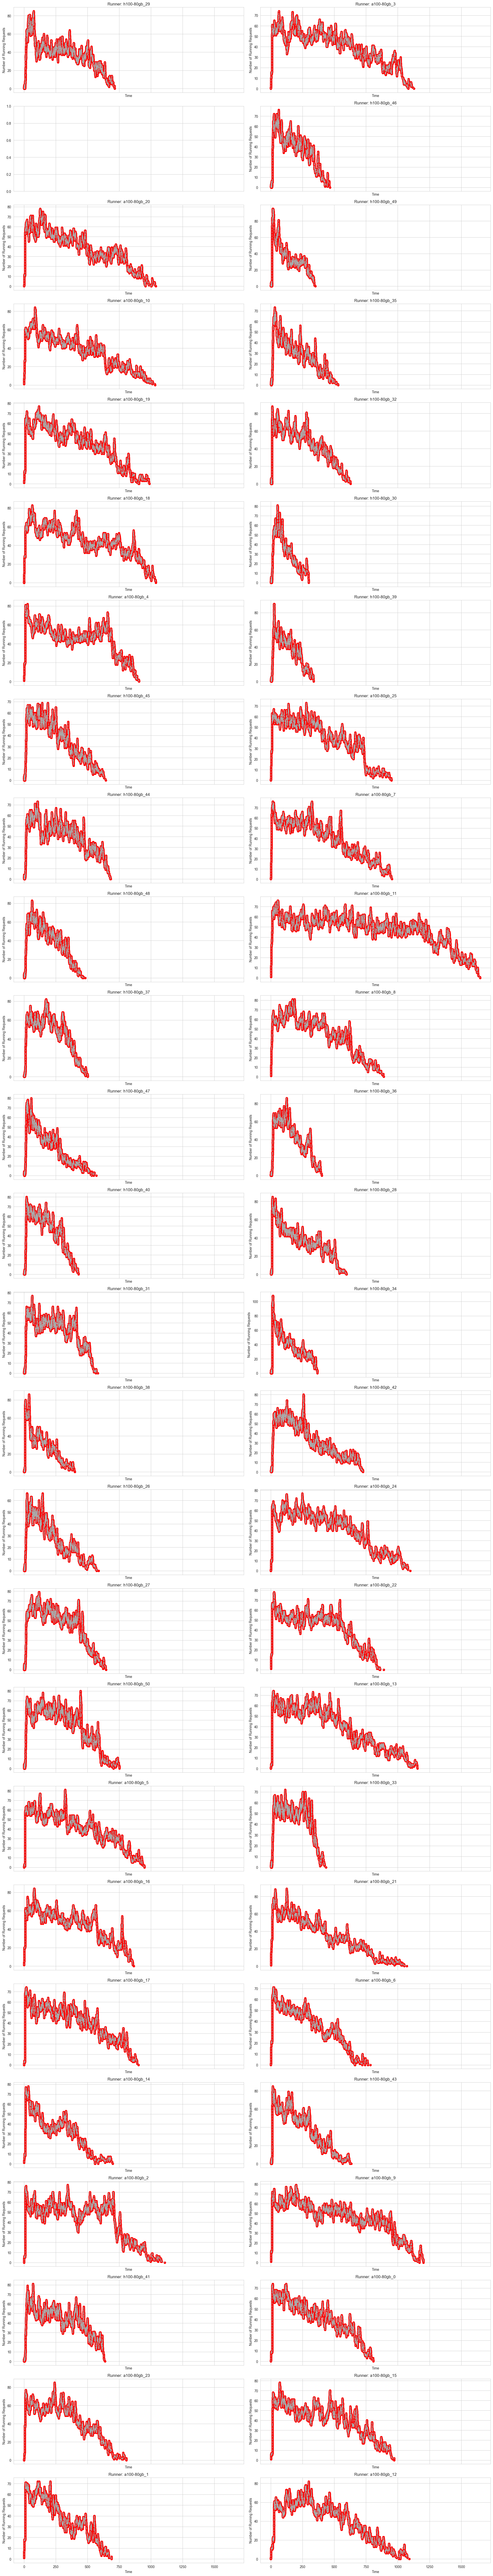

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import math


def rq_analysis(experiment_root):
    # Read the data into a pandas DataFrame
    df = pd.read_csv(experiment_root + '/request_nodes.csv')

    # Convert timestamps to float
    df['start_timestamp'] = df['start_timestamp'].astype(float)
    df['completion_timestamp'] = df['completion_timestamp'].astype(float)

    # Get unique runners
    runners = df['runner'].unique()

    # Set up subplots
    num_runners = len(runners)
    cols = 2
    rows = math.ceil(num_runners / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows), sharex=True)

    # Flatten axes array for easy indexing
    axes = axes.flatten()

    # Process and plot data for each runner
    for i, runner in enumerate(runners):
        runner_df = df[df['runner'] == runner]
        if runner == 'DummyLink':
            continue

        events = []

        # Collect start and end events
        for idx, row in runner_df.iterrows():
            events.append({'time': row['start_timestamp'], 'type': 'start'})
            events.append({'time': row['completion_timestamp'], 'type': 'end'})

        # Sort events by time
        #events.sort(key=lambda x: (x['time'], 0 if x['type'] == 'start' else 1))
        events.sort(key=lambda x: x['time'])

        # Build the step function data
        times = []
        counts = []
        current_count = 0
        for event in events:
            times.append(event['time'])
            #counts.append(current_count)
            if event['type'] == 'start':
                current_count += 1
            else:
                current_count -= 1
            #times.append(event['time'])
            counts.append(current_count)

        # Plot the data
        ax = axes[i]
        ax.plot(times, counts, linestyle='--', color='darkgrey')  # Use broken line and dark grey color
        ax.scatter(times, counts, color='red')  # Highlight data points
        ax.set_title(f"Runner: {runner}")
        ax.set_xlabel('Time')
        ax.set_ylabel('Number of Running Requests')
        ax.grid(True)

    # # Hide any unused subplots
    # for j in range(i + 1, len(axes)):
    #     fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# Test the function 
#experiment_root = '../results/0/splitwise_27_13/rr_conv_30/40_0/bloom-176b/mixed_pool/'
#experiment_root = '../results/0/splitwise_1_1/rr_conv_30/26_25/bloom-176b/mixed_pool/'
#experiment_root = '../results/0/splitwise_1_1/rr_conv_100/26_25/bloom-176b/mixed_pool/'
experiment_root = '../results/0/splitwise_1_1/rr_conv_250/26_25/bloom-176b/mixed_pool/'

rq_analysis(experiment_root=experiment_root)

If number of requests are more than one, this means there are parallel requests running in a machine. Next, we analyze number of tasks scheduled on the cpu cores of the machines.

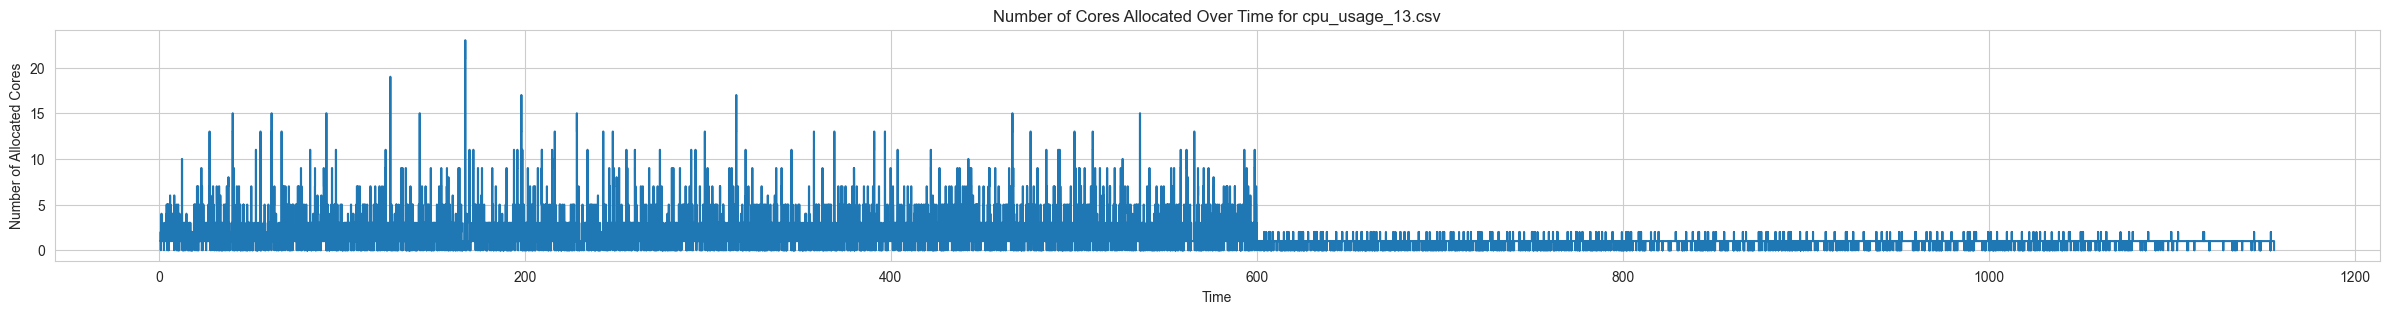

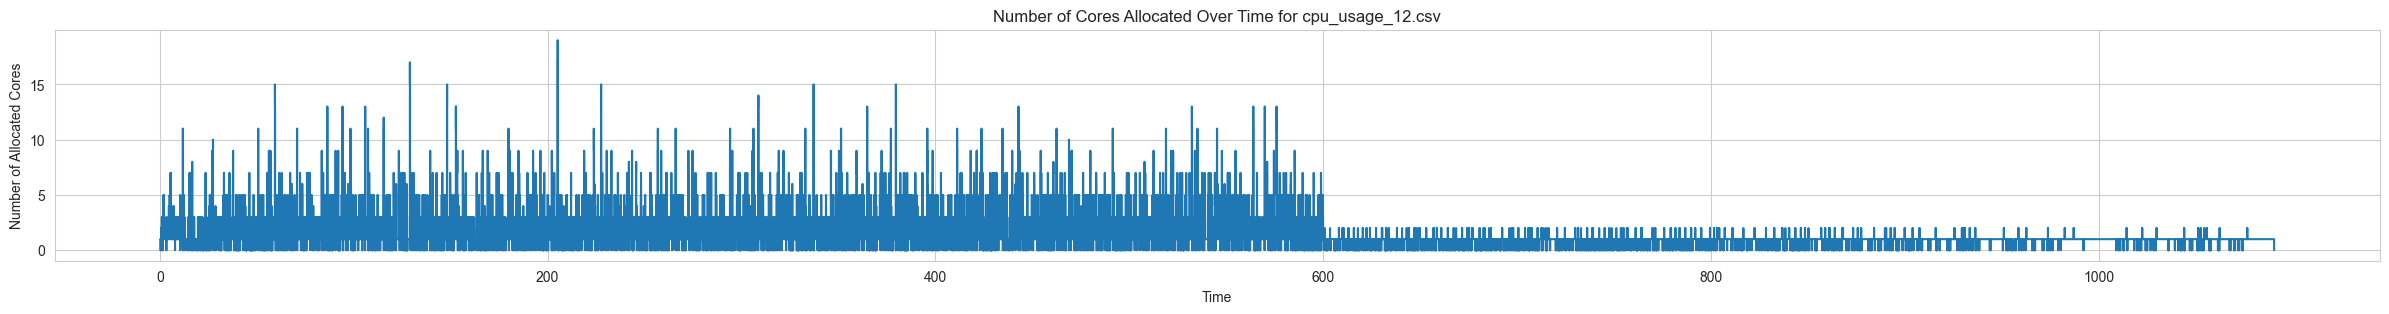

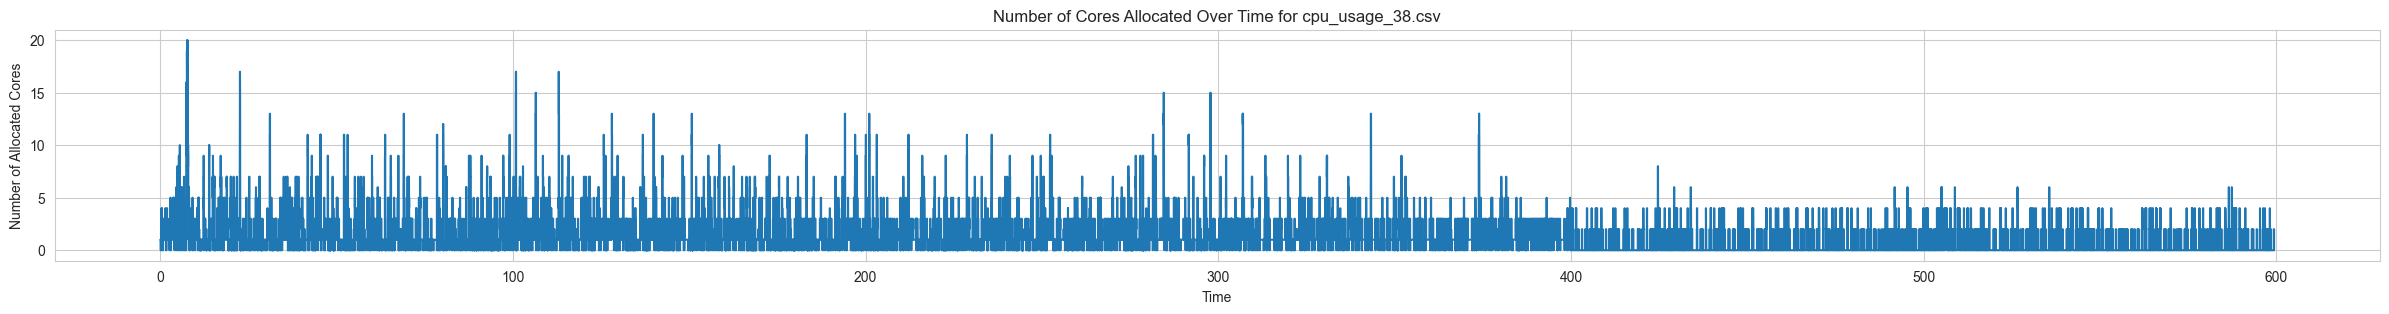

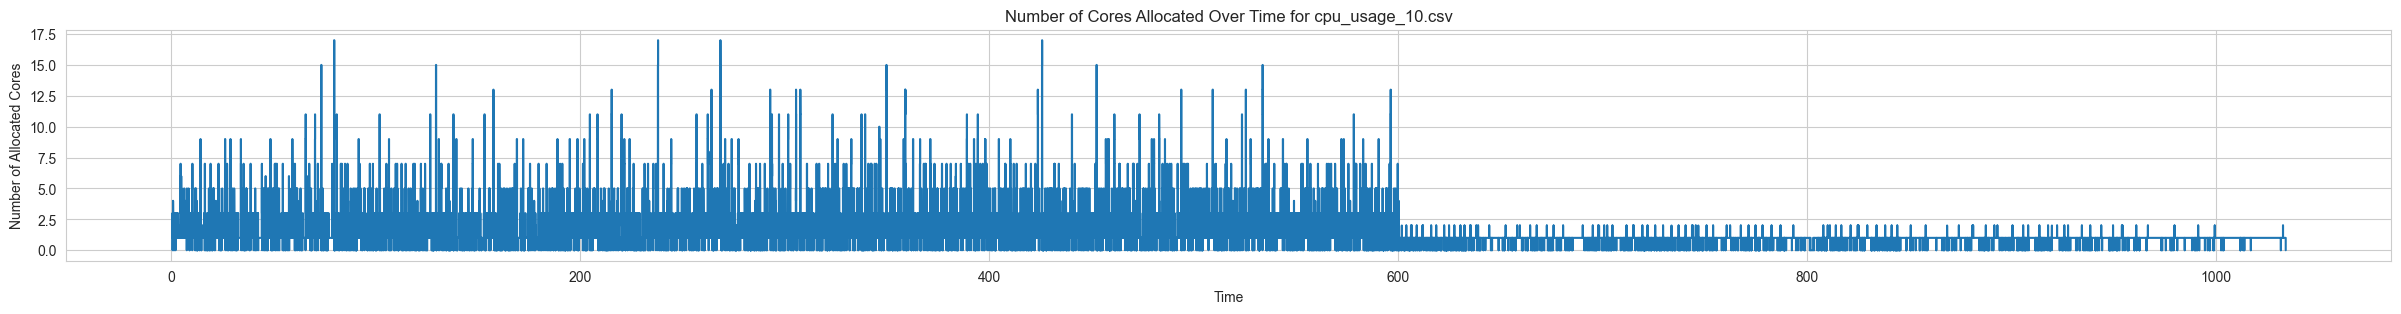

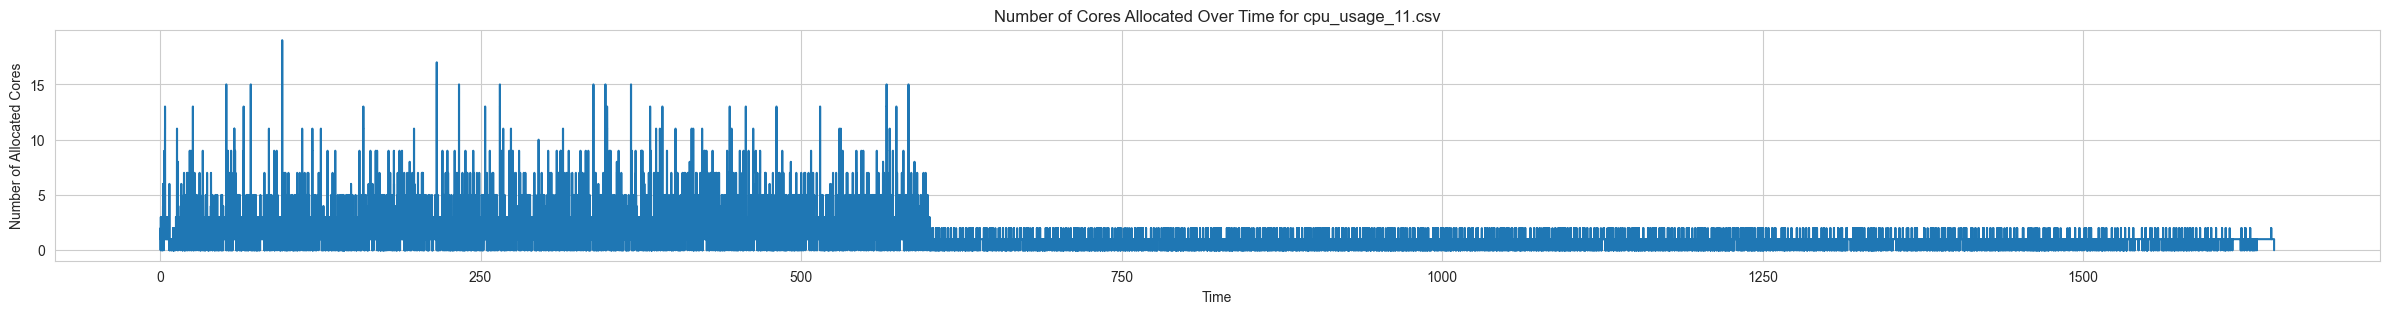

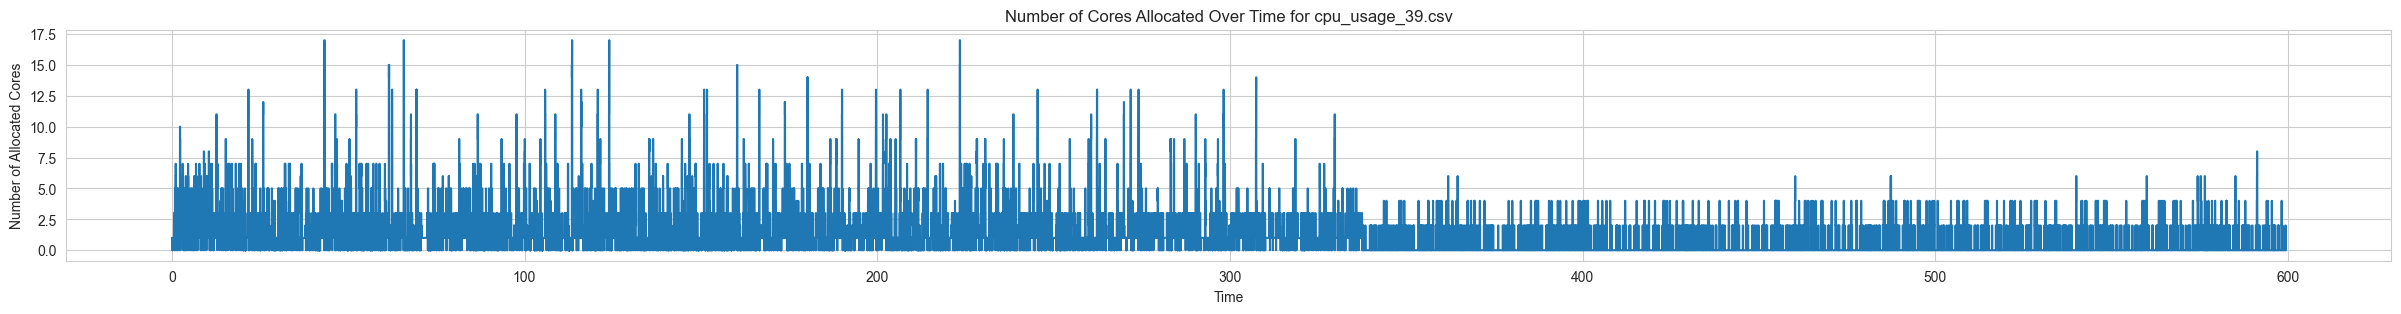

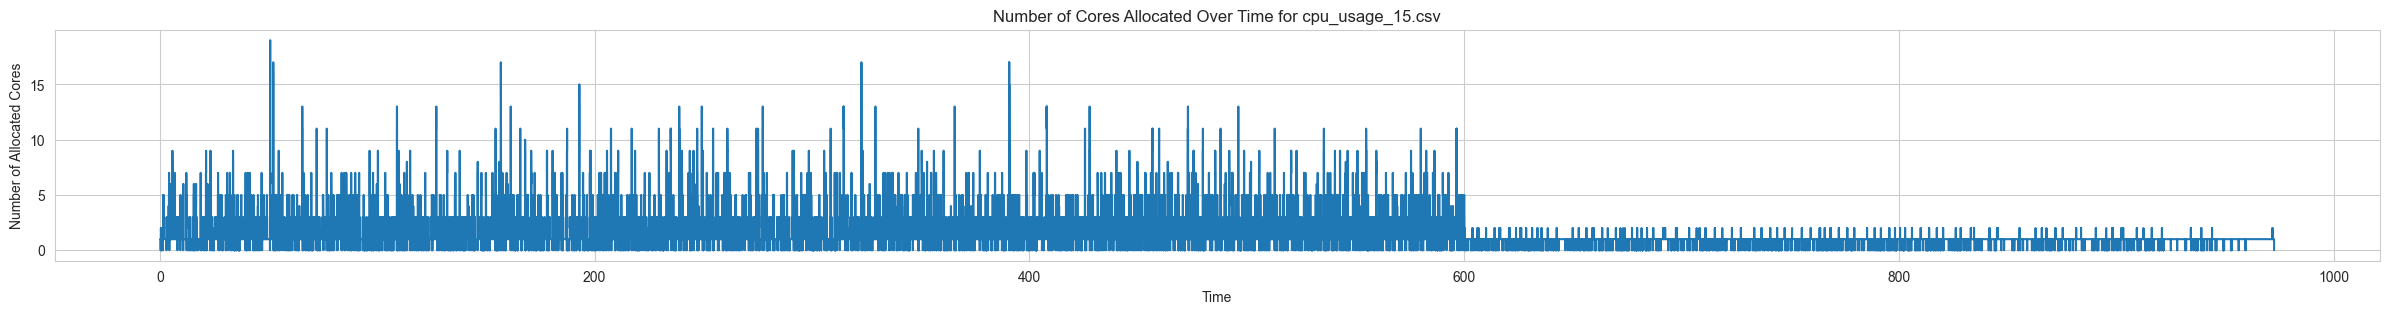

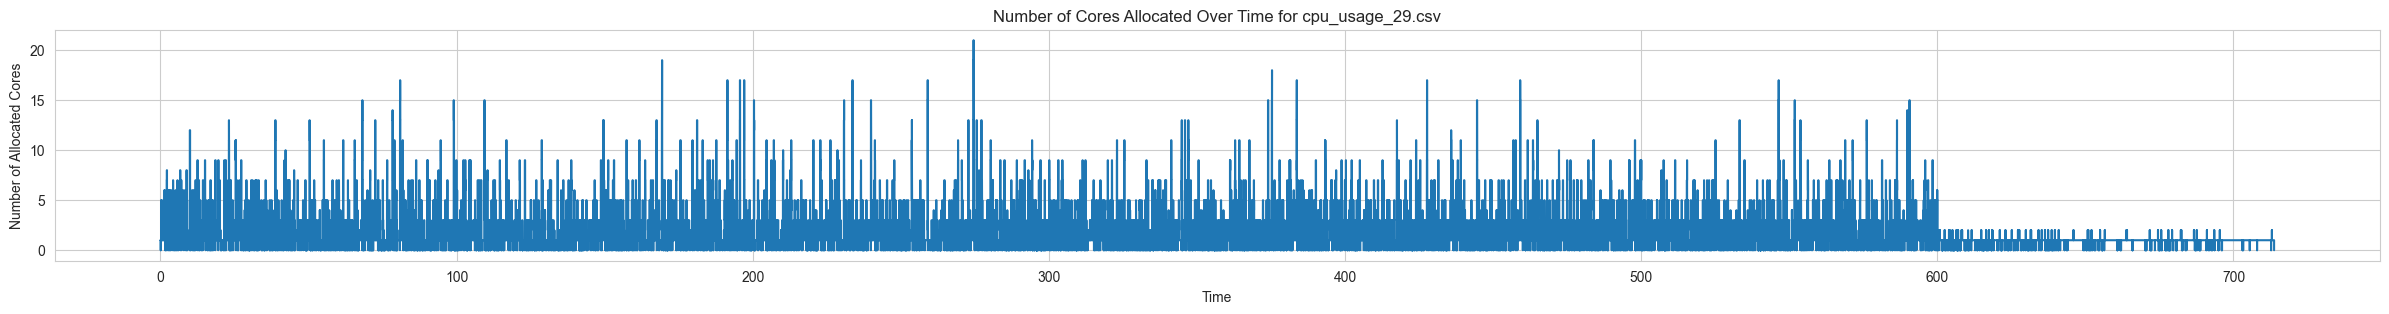

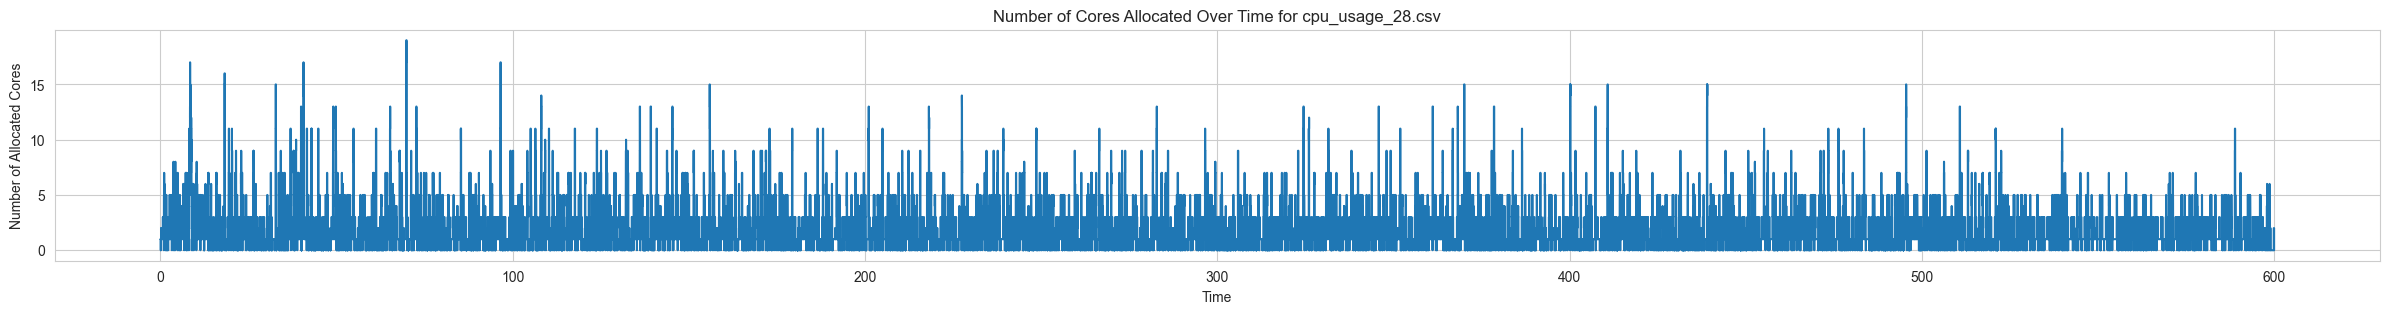

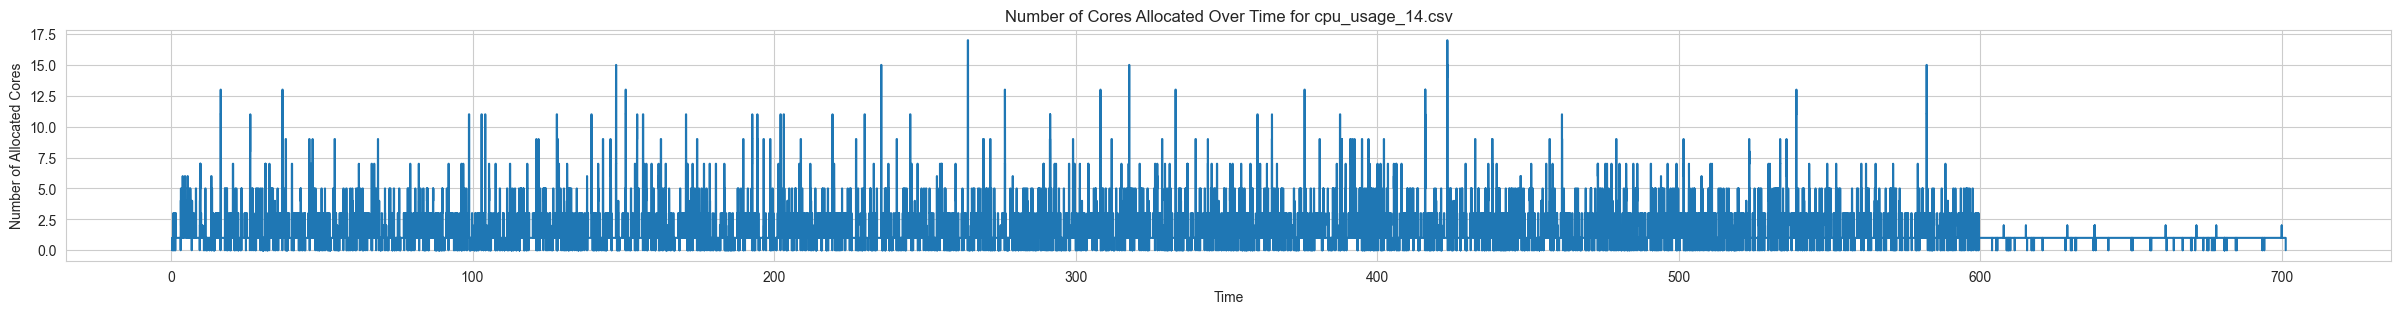

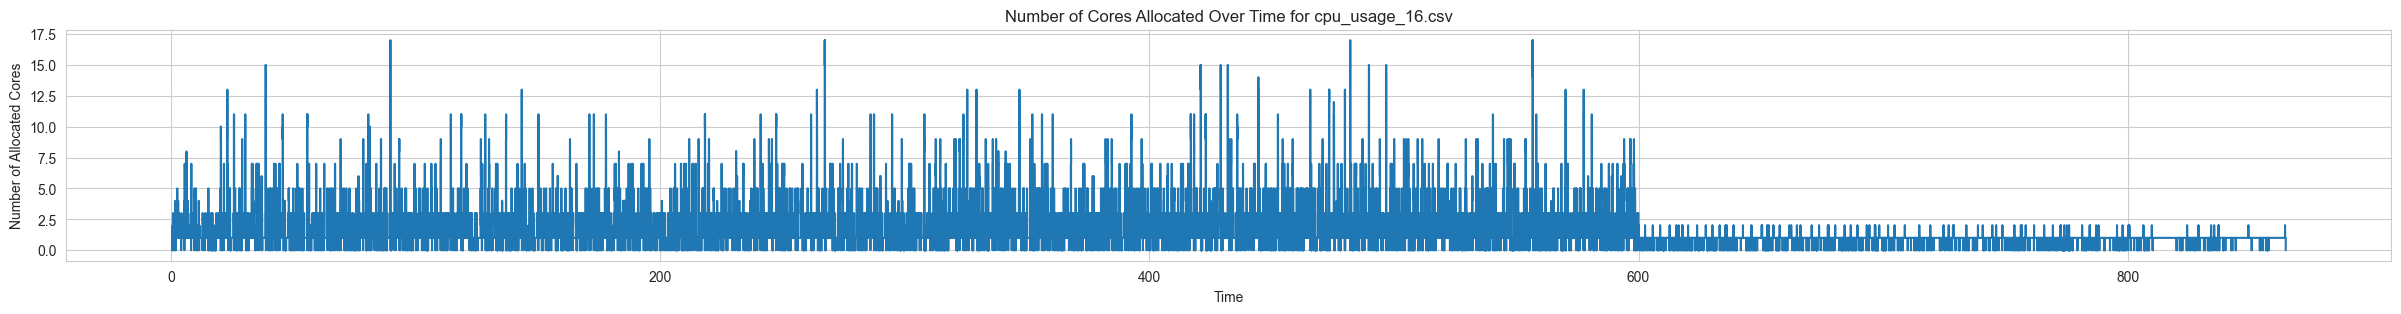

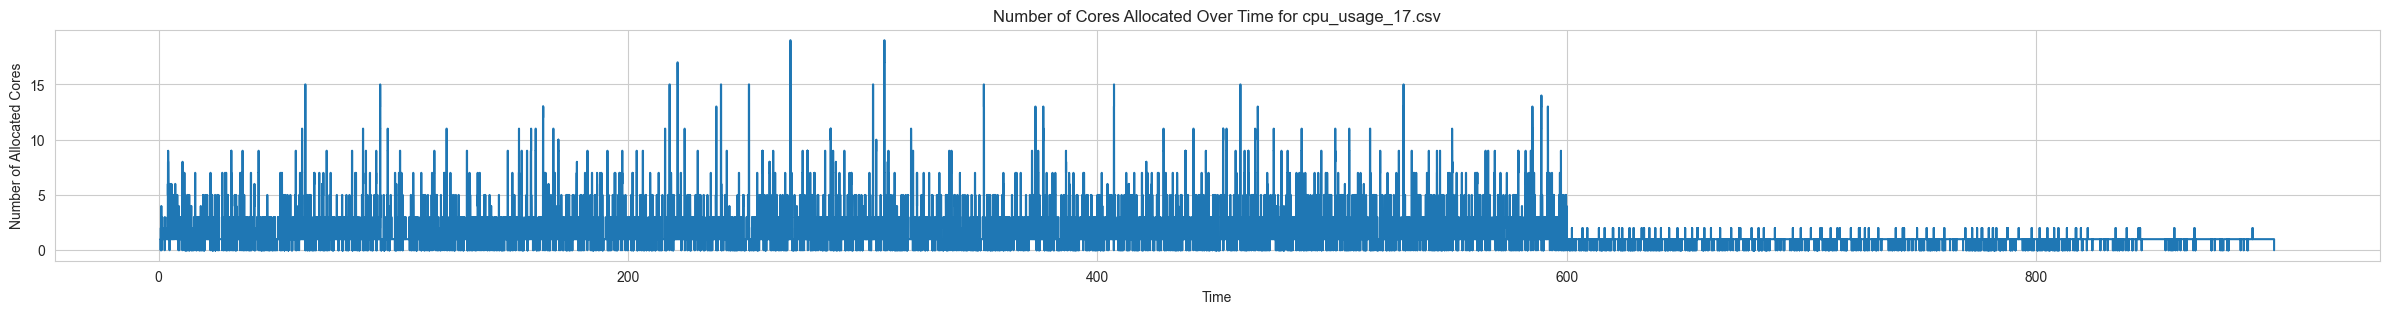

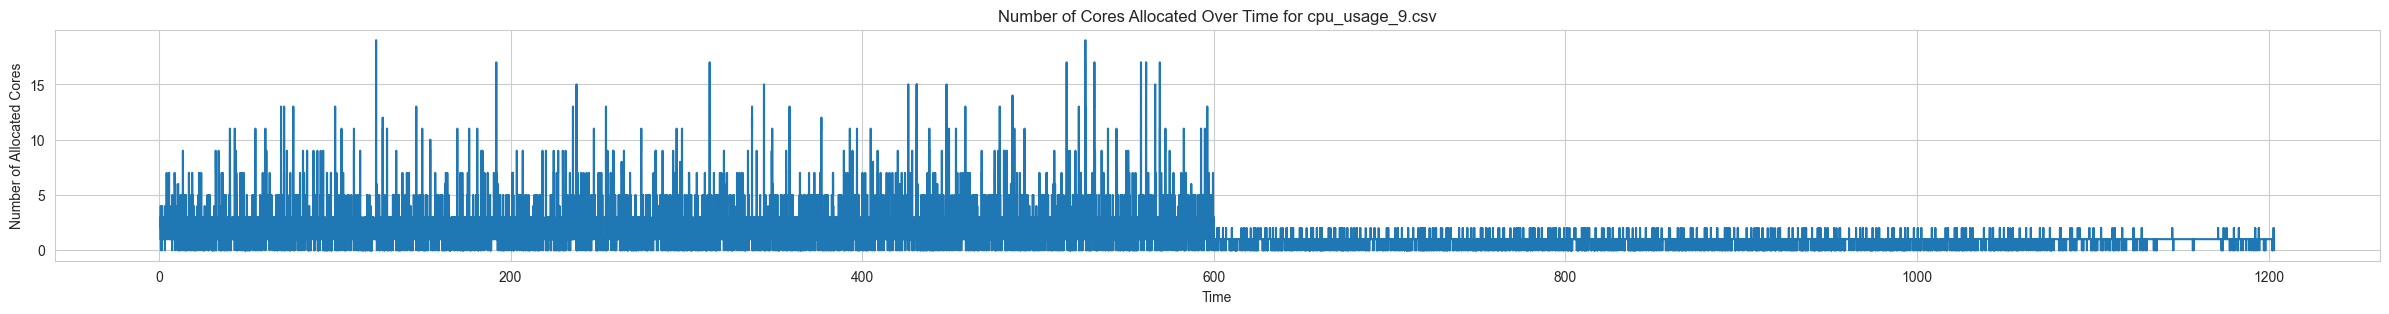

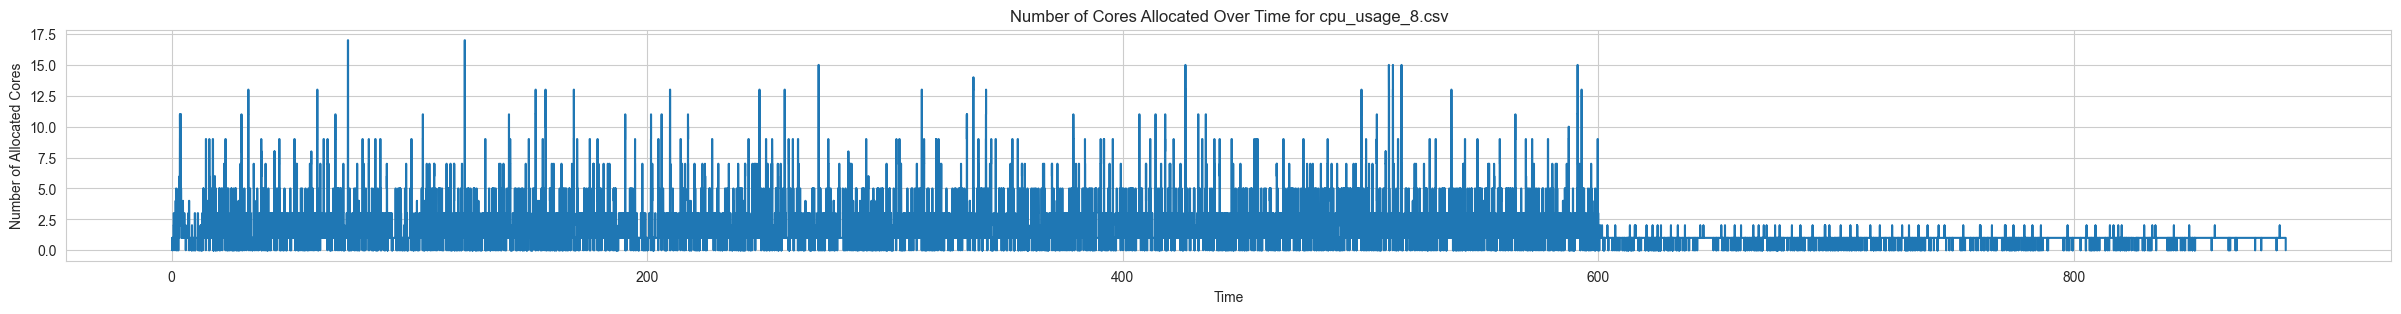

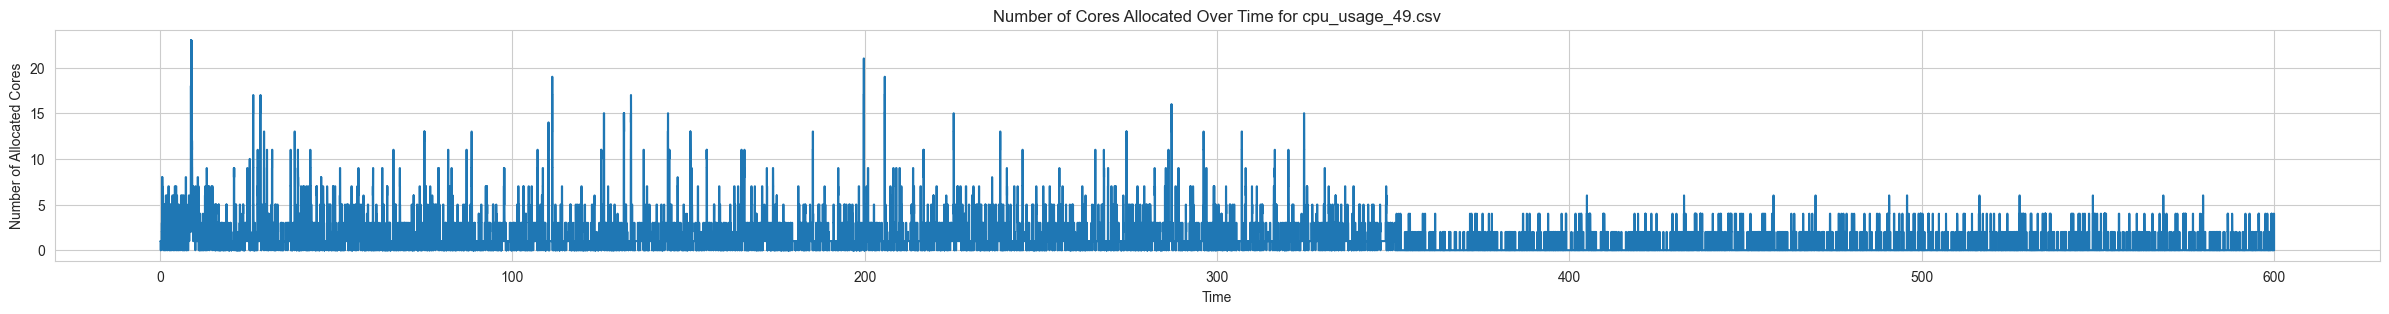

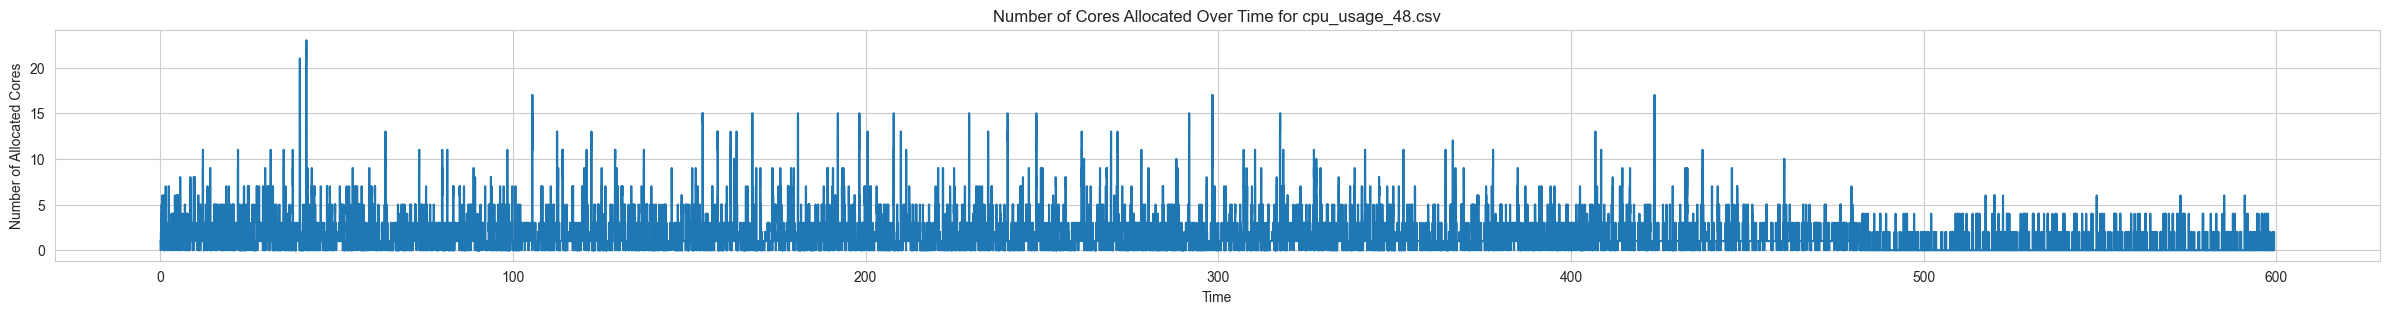

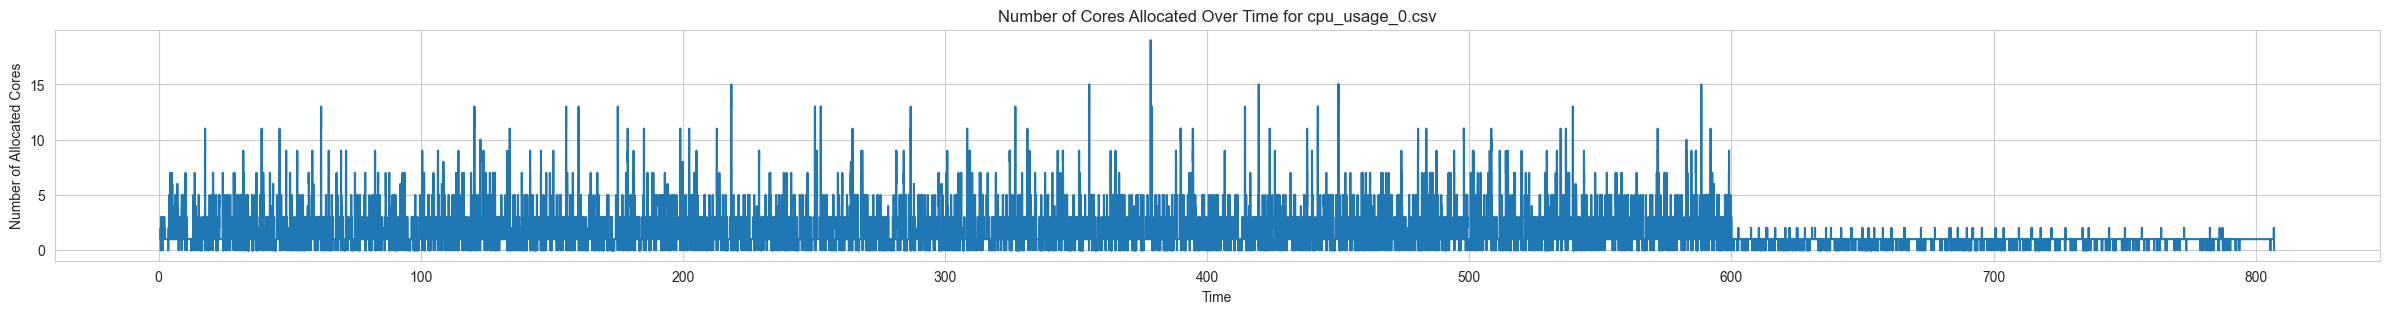

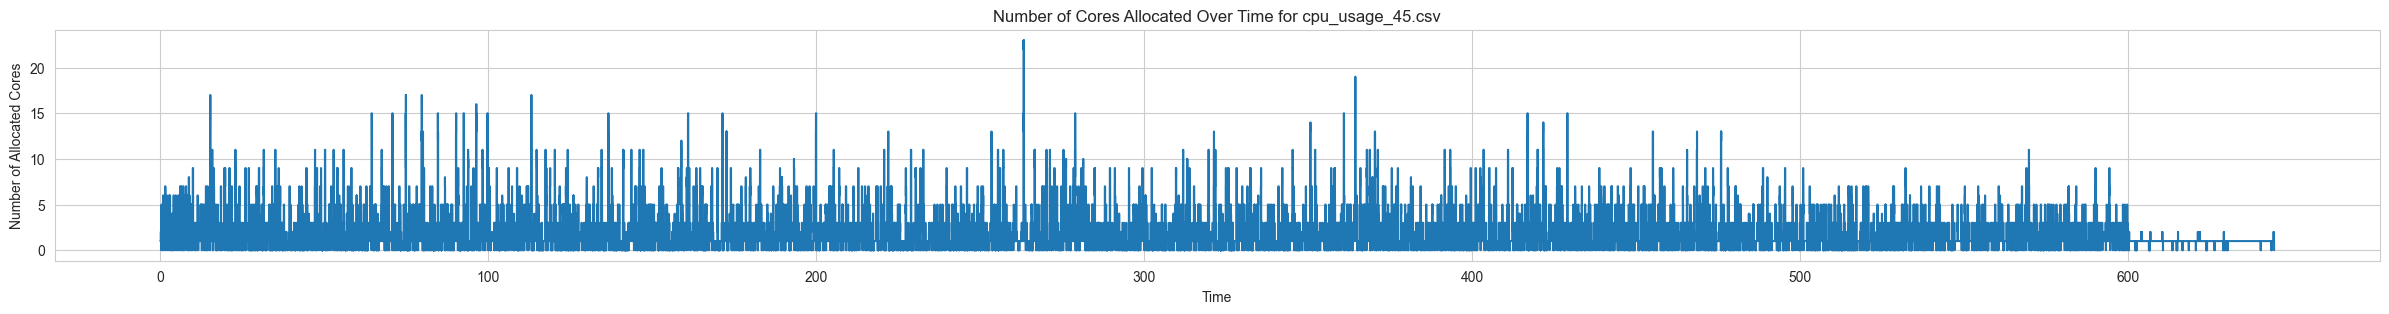

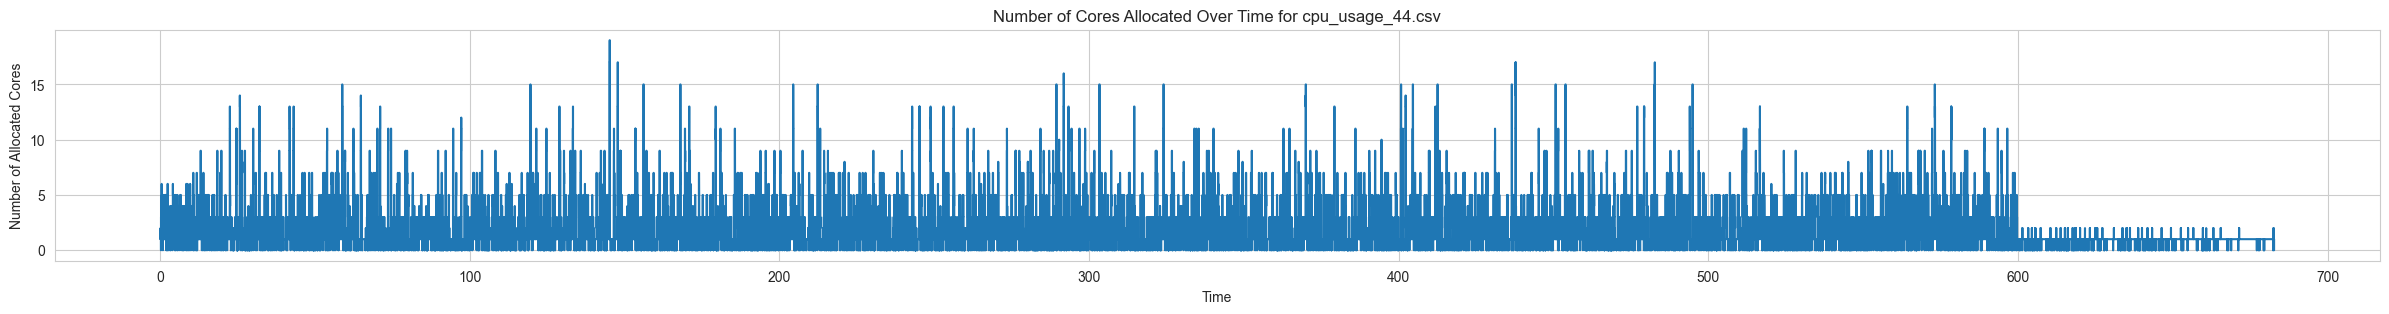

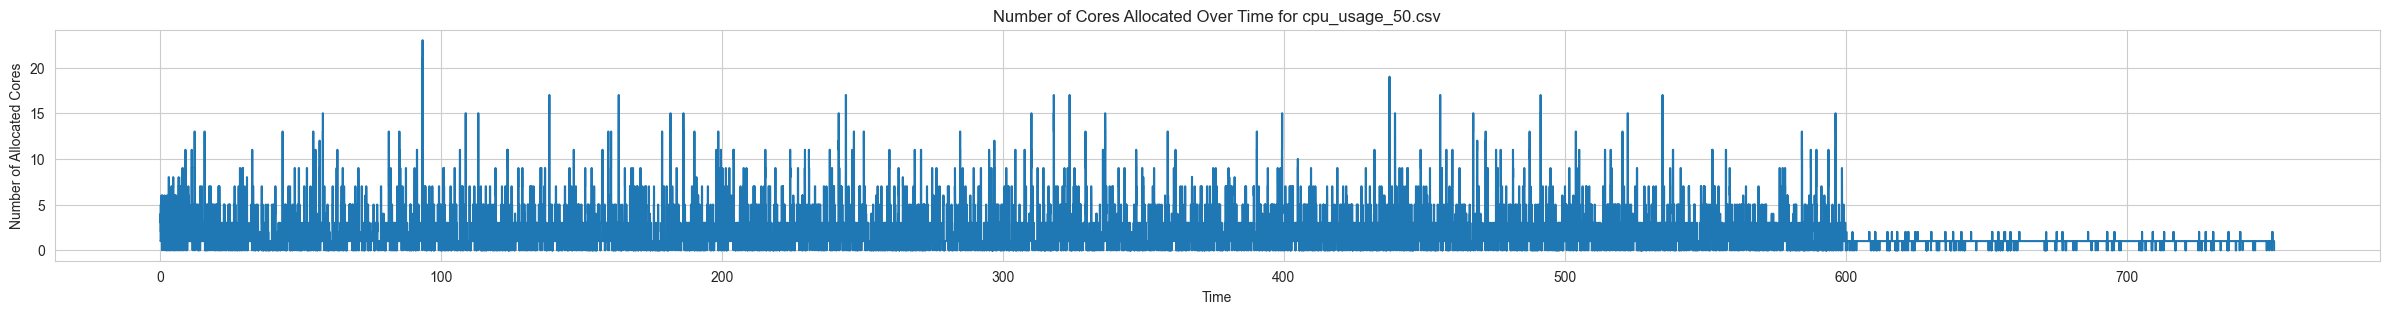

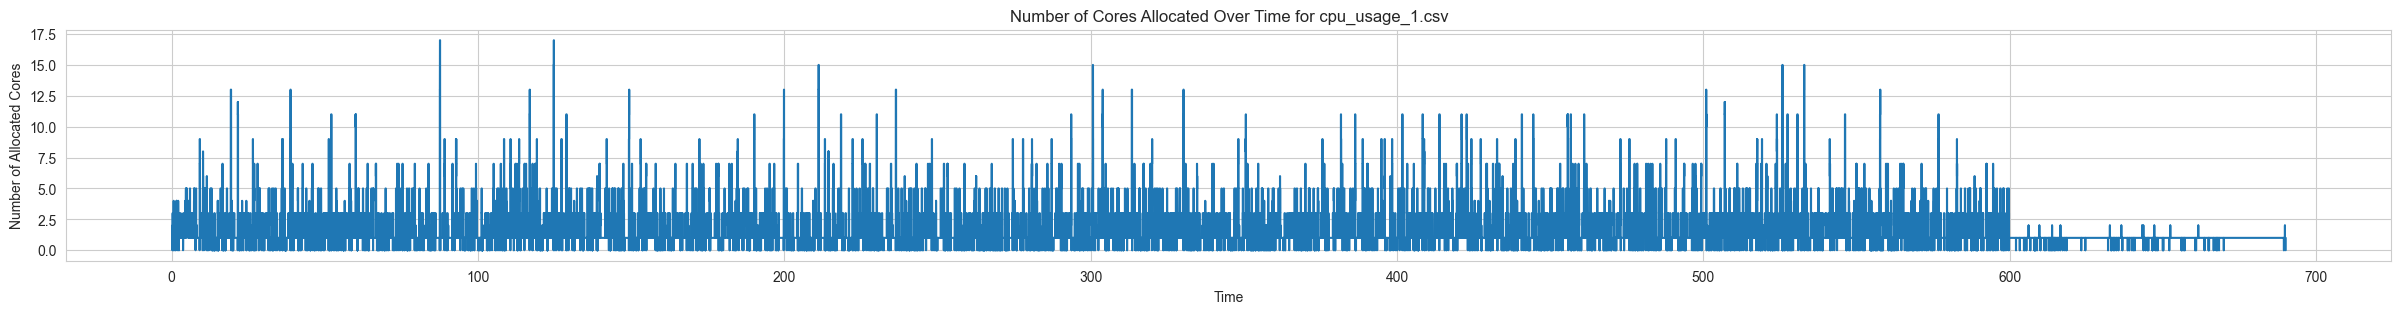

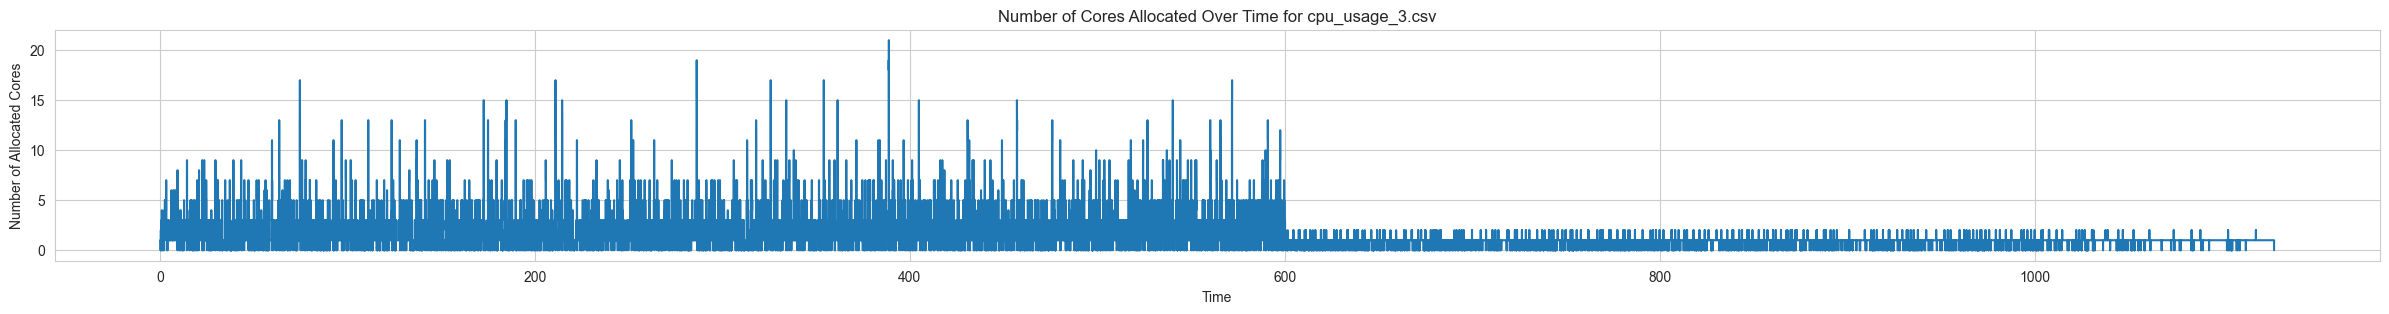

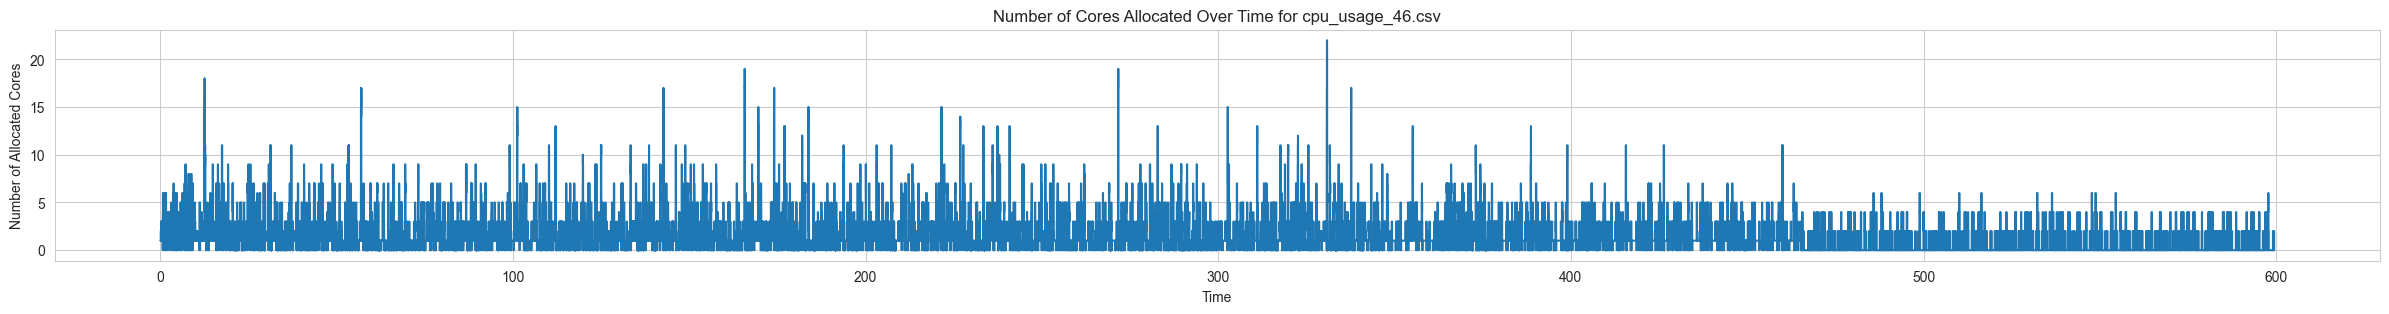

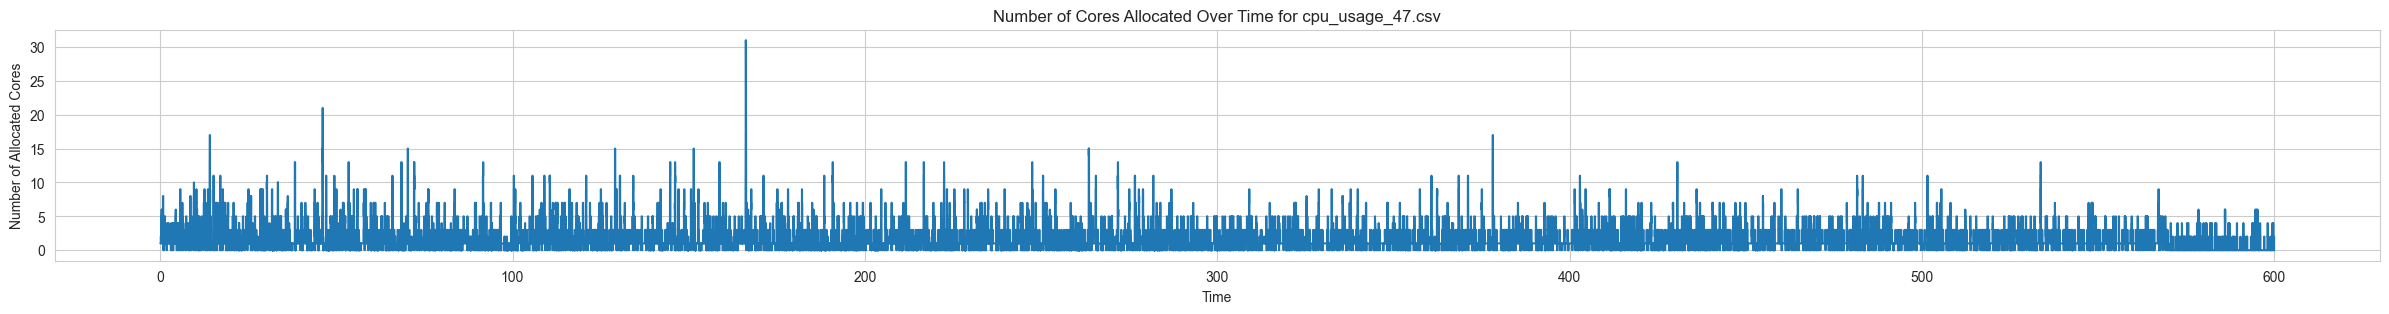

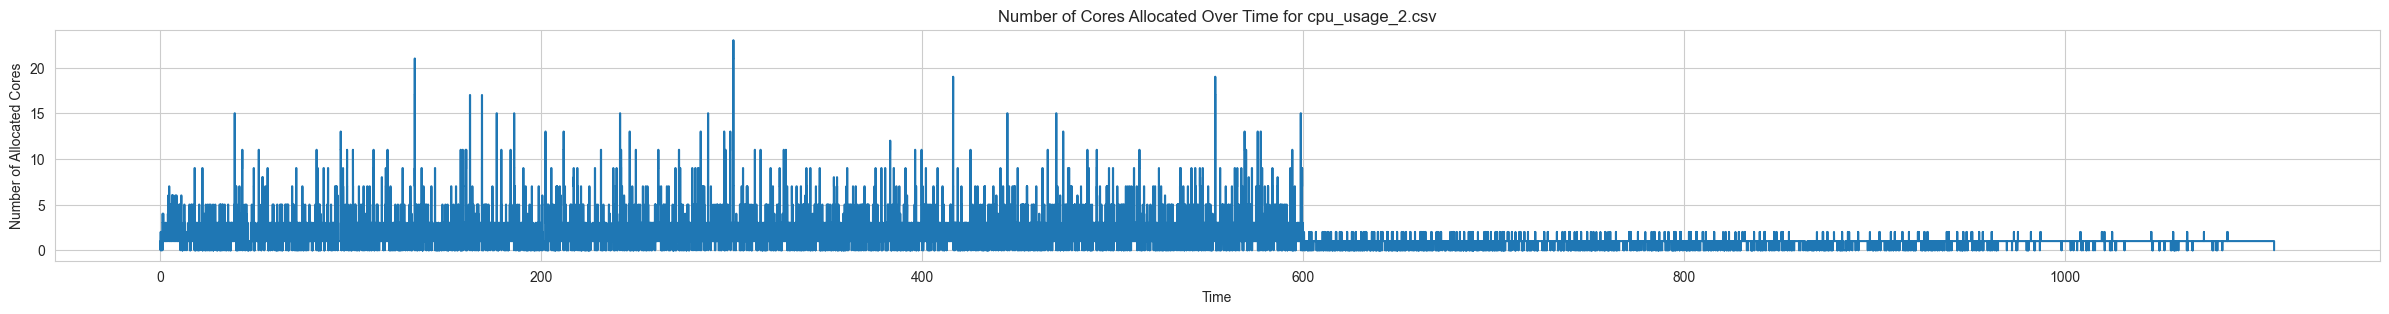

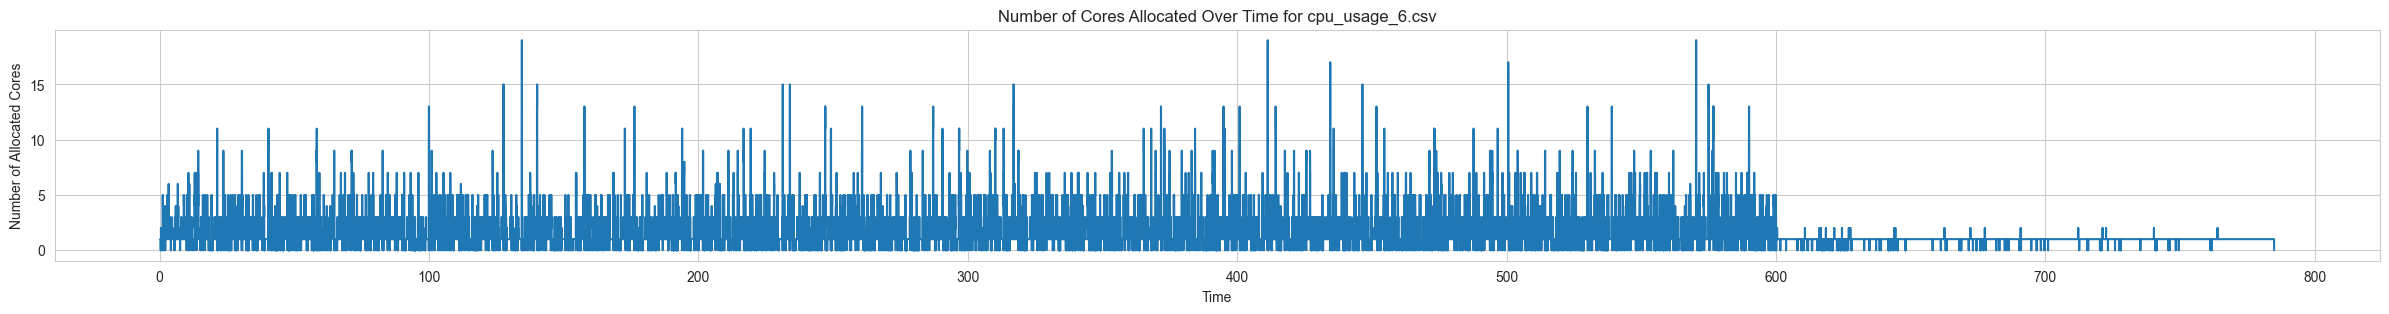

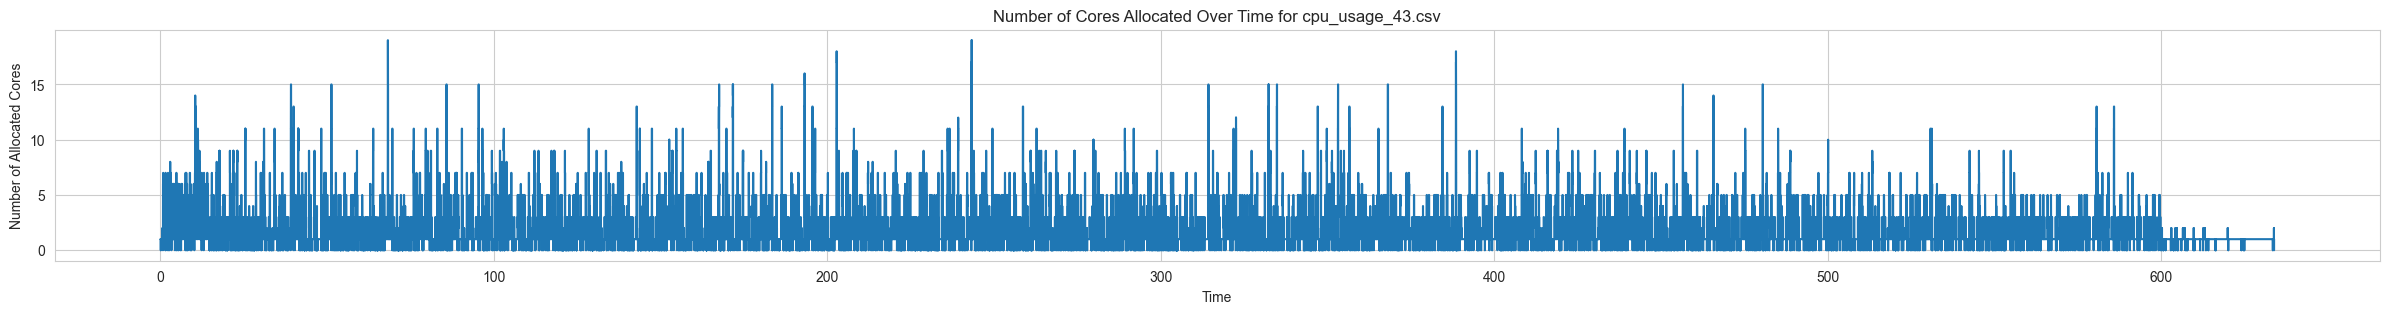

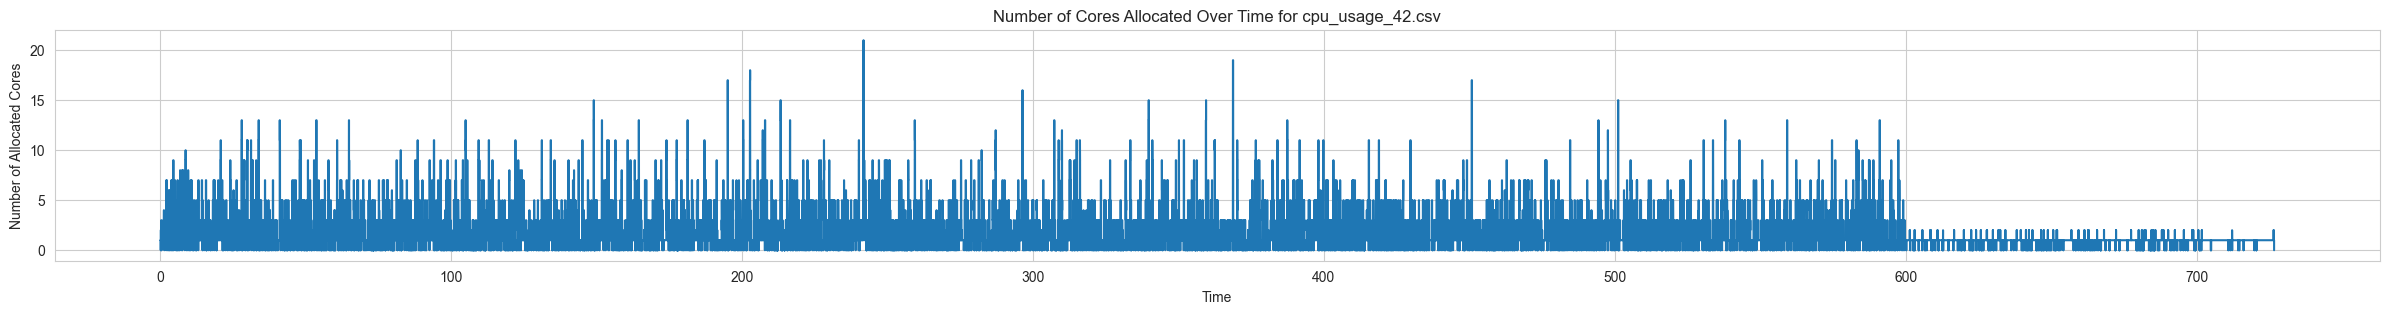

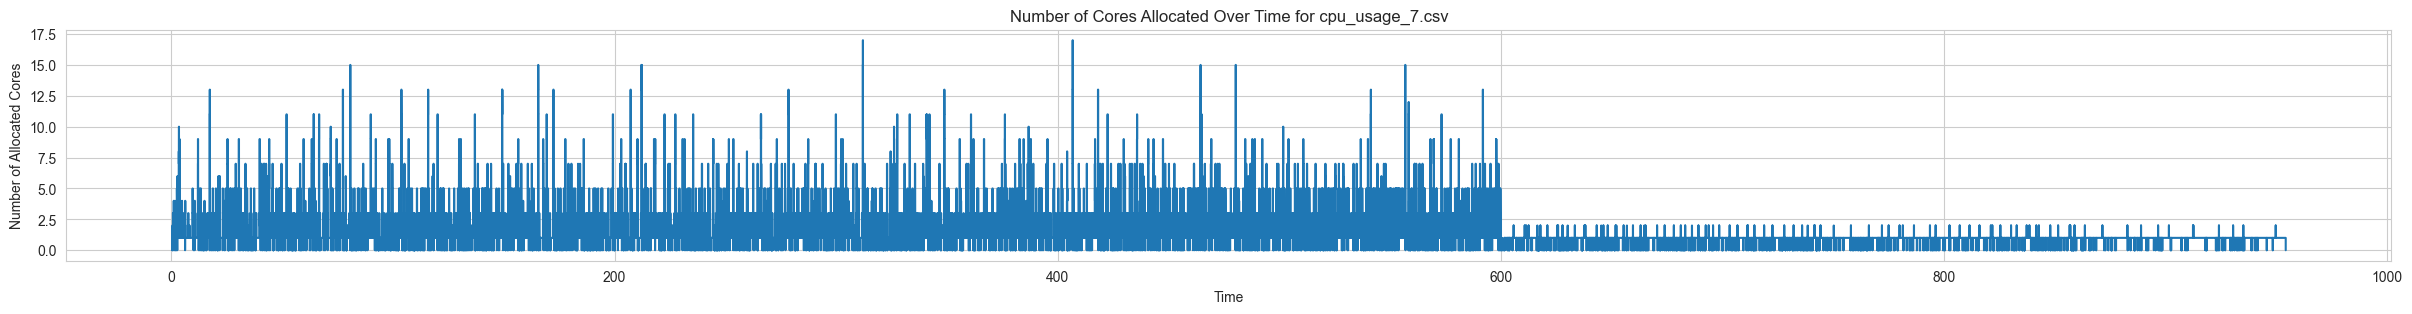

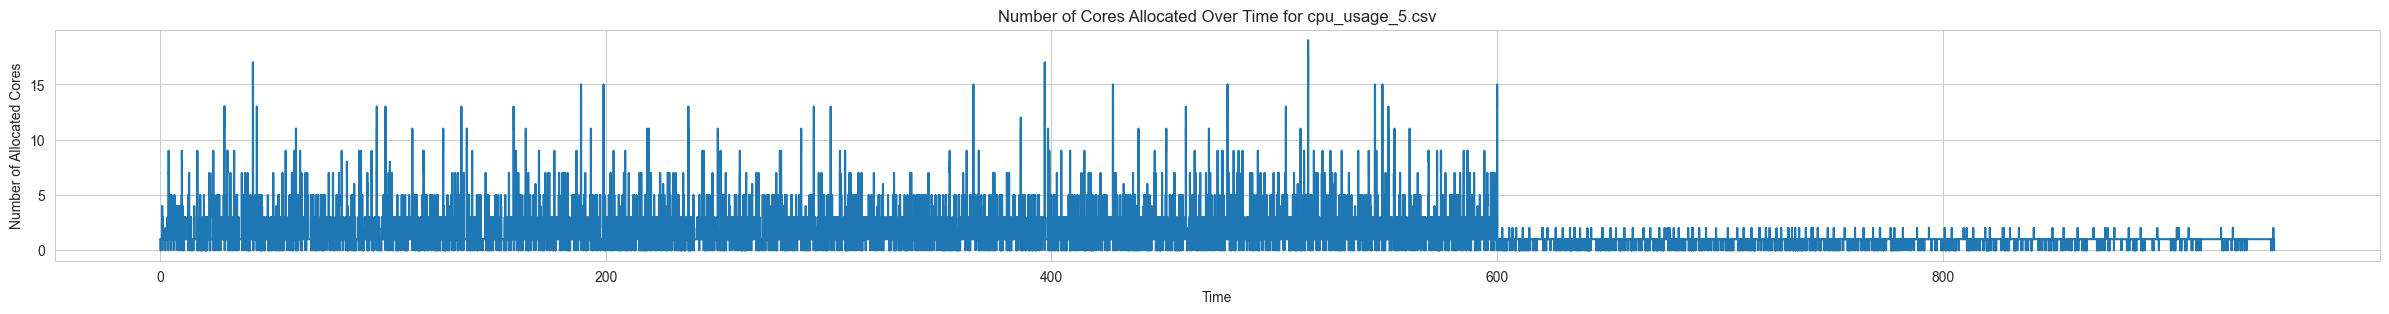

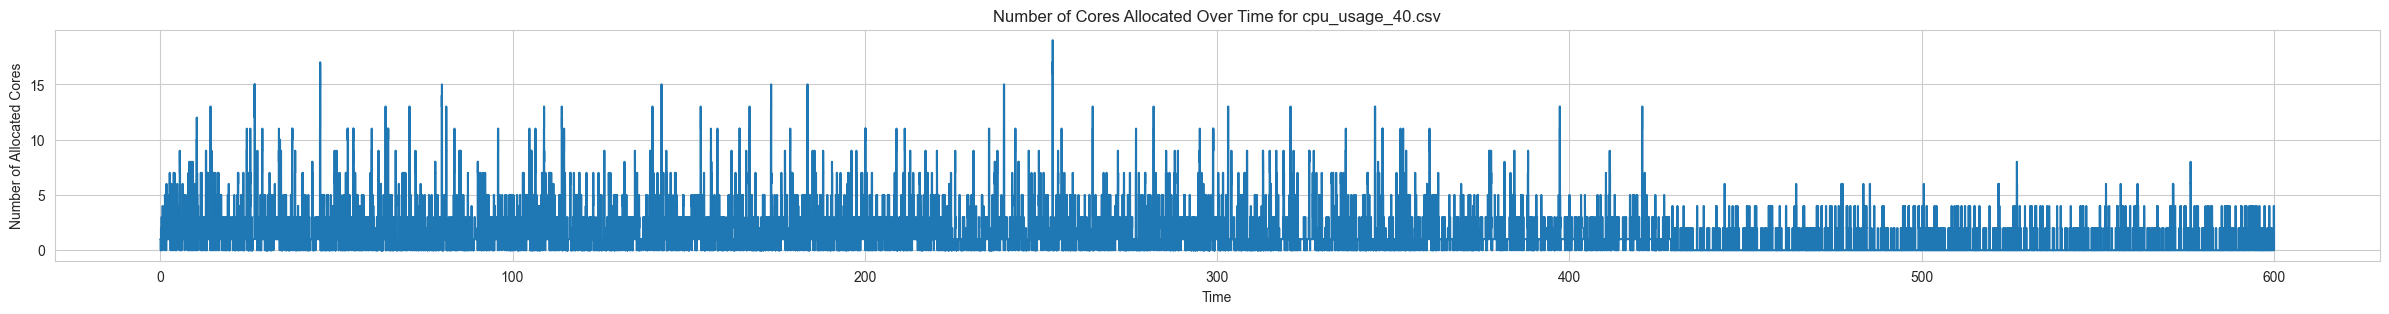

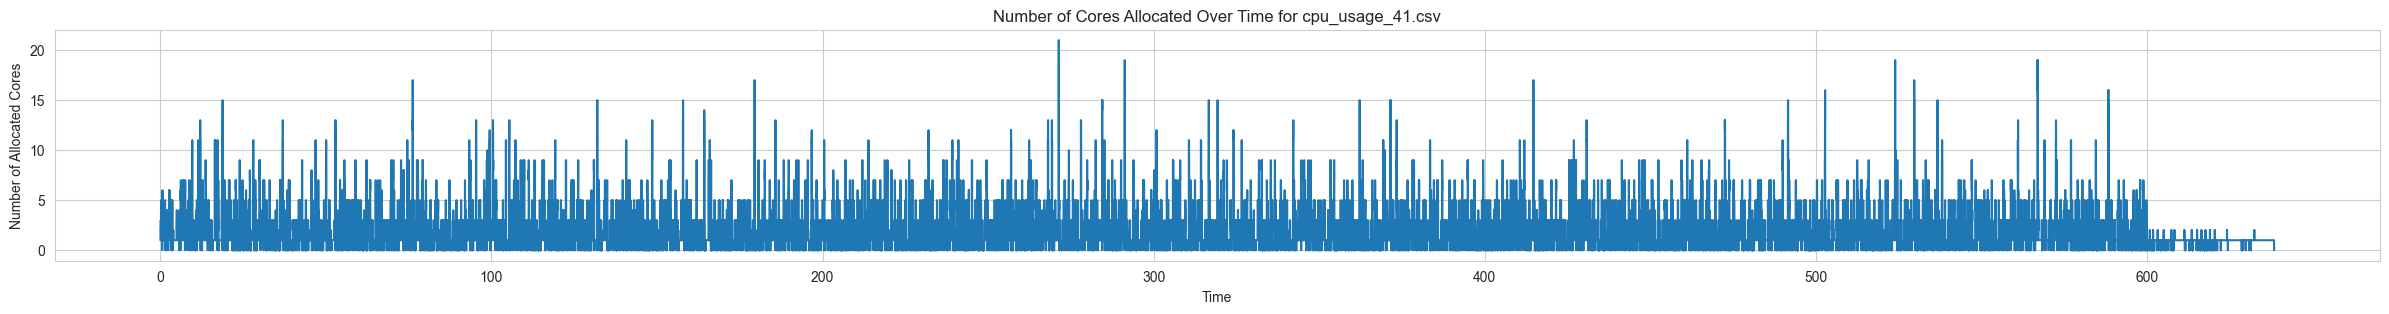

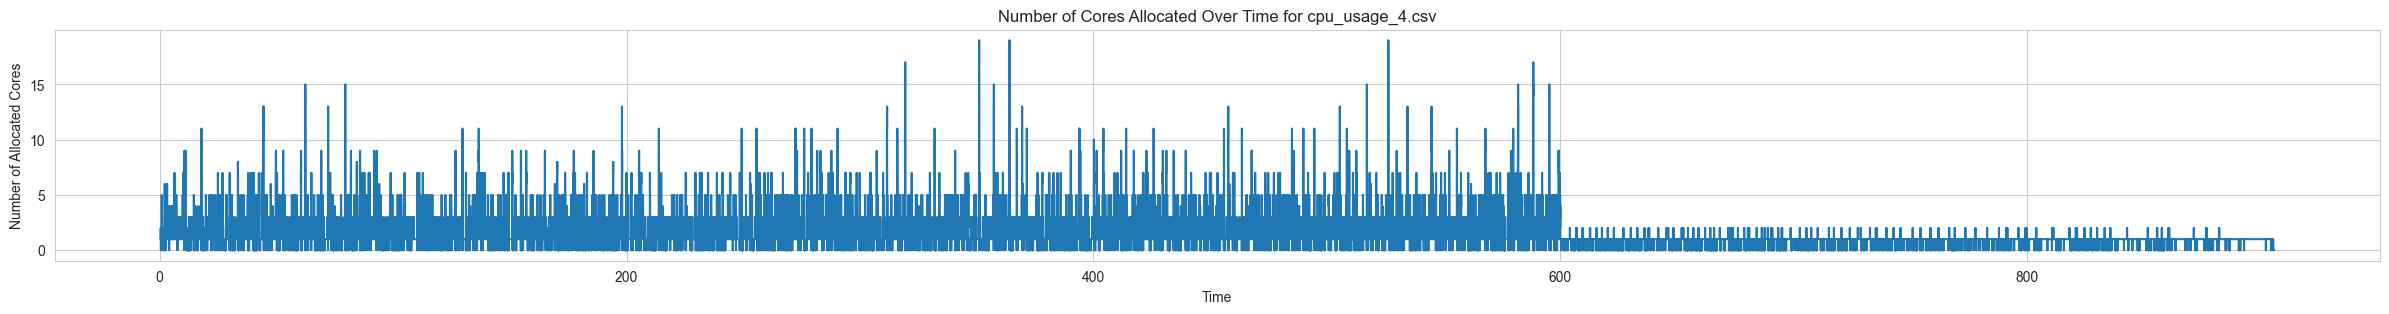

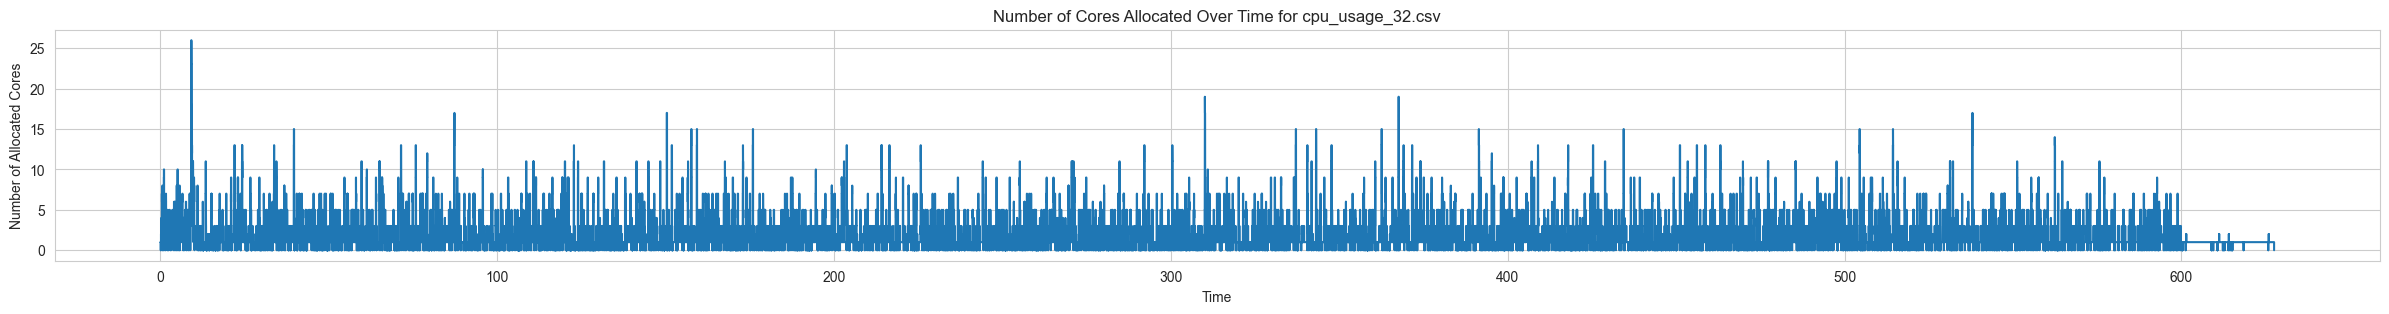

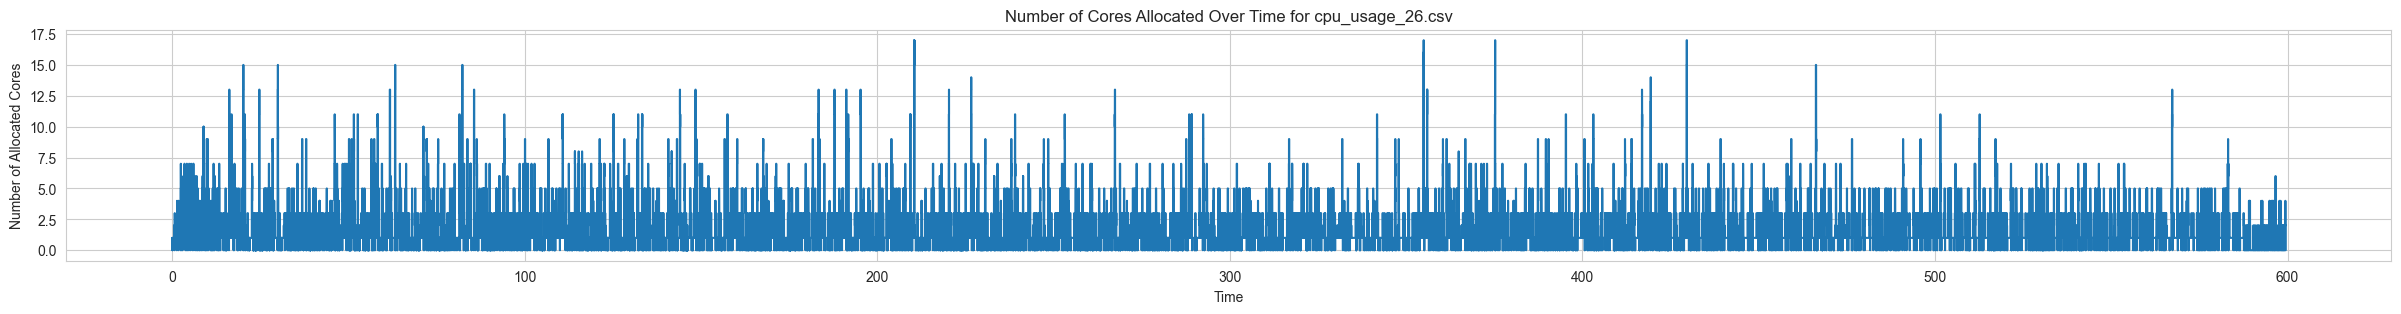

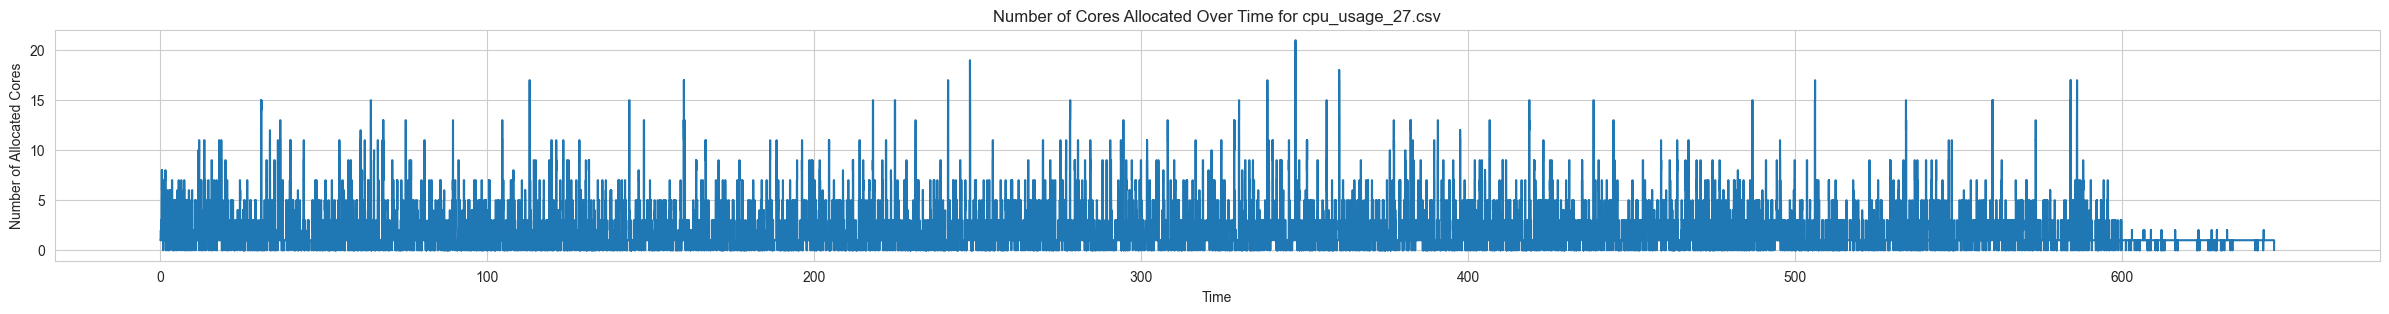

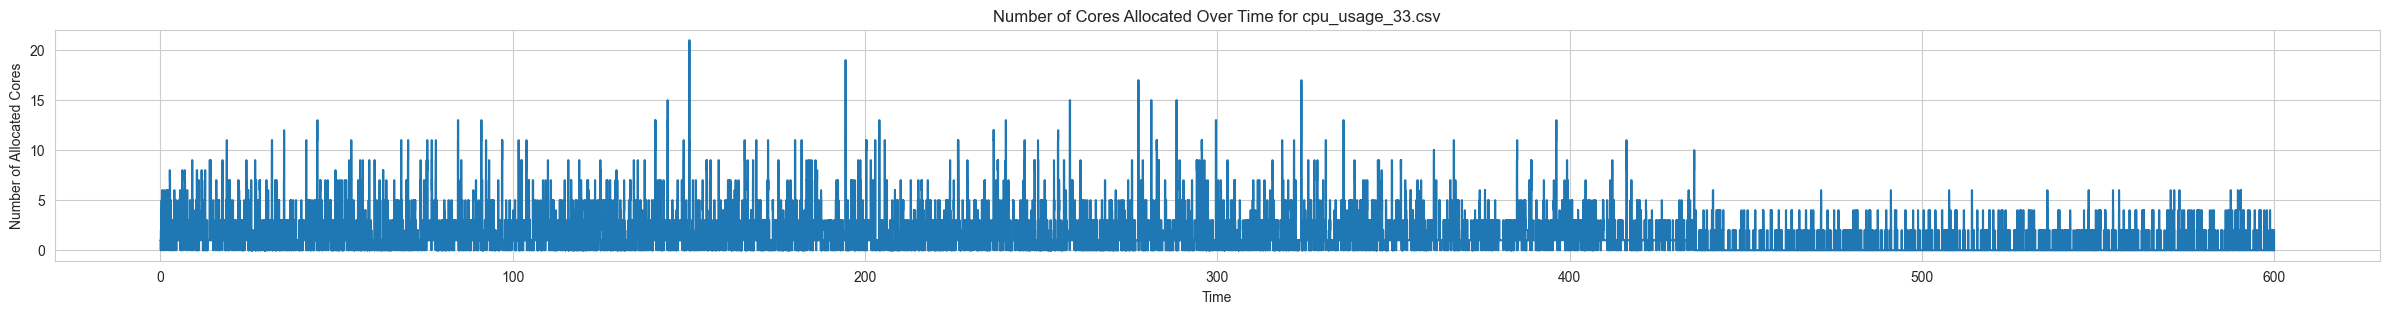

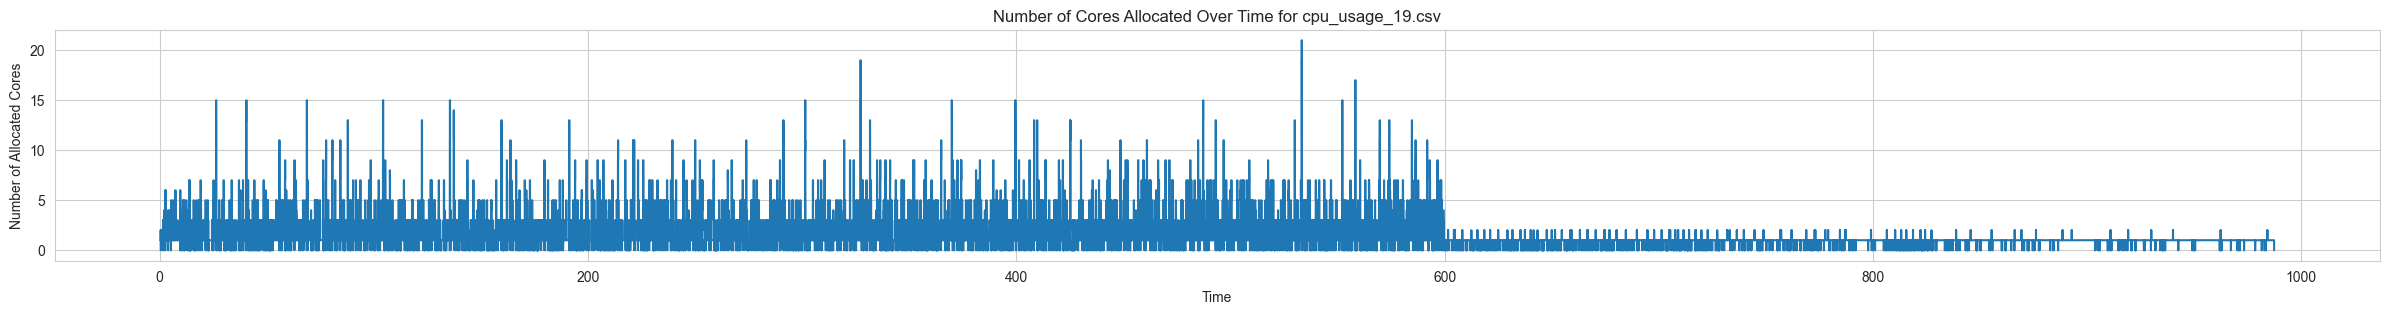

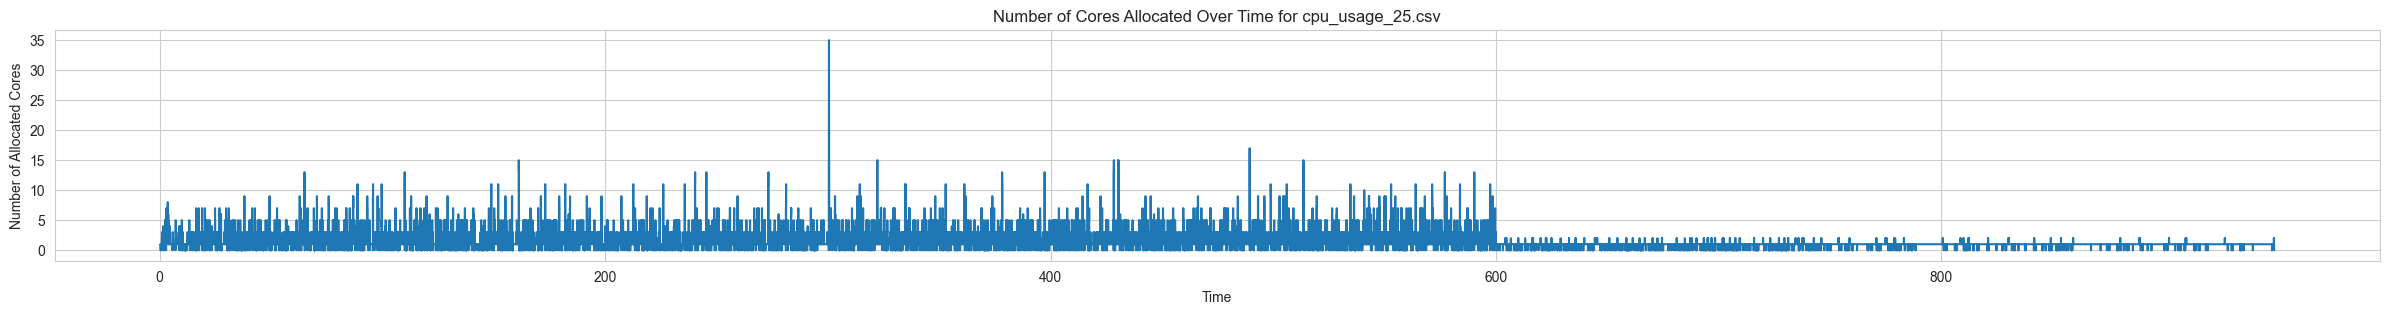

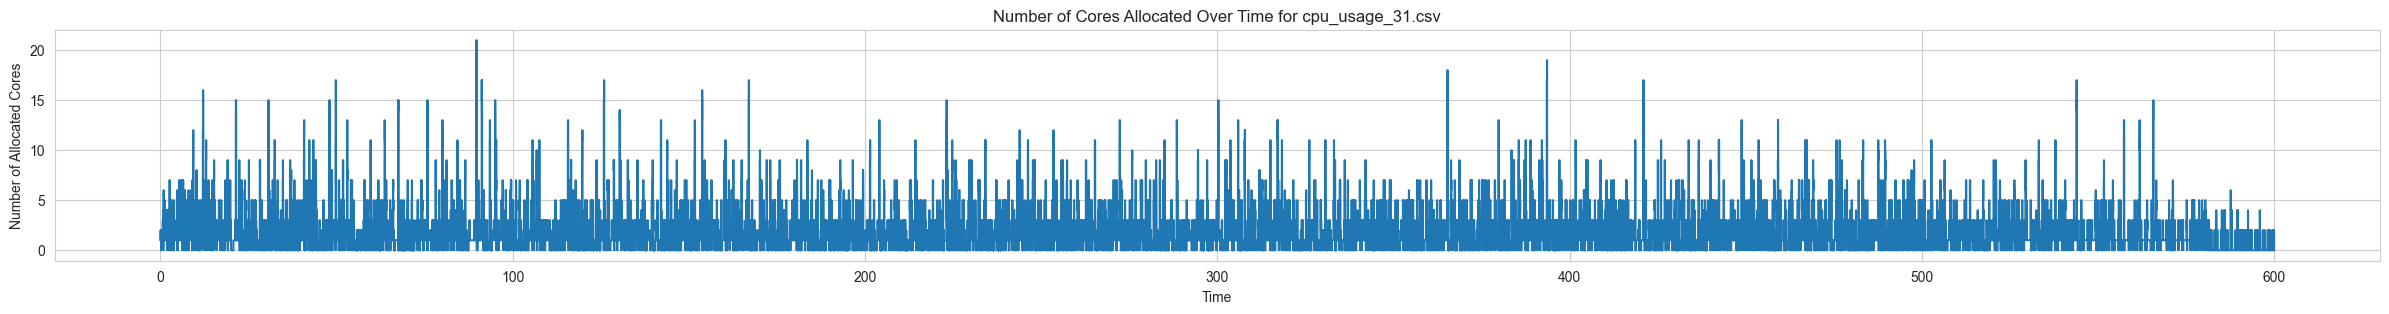

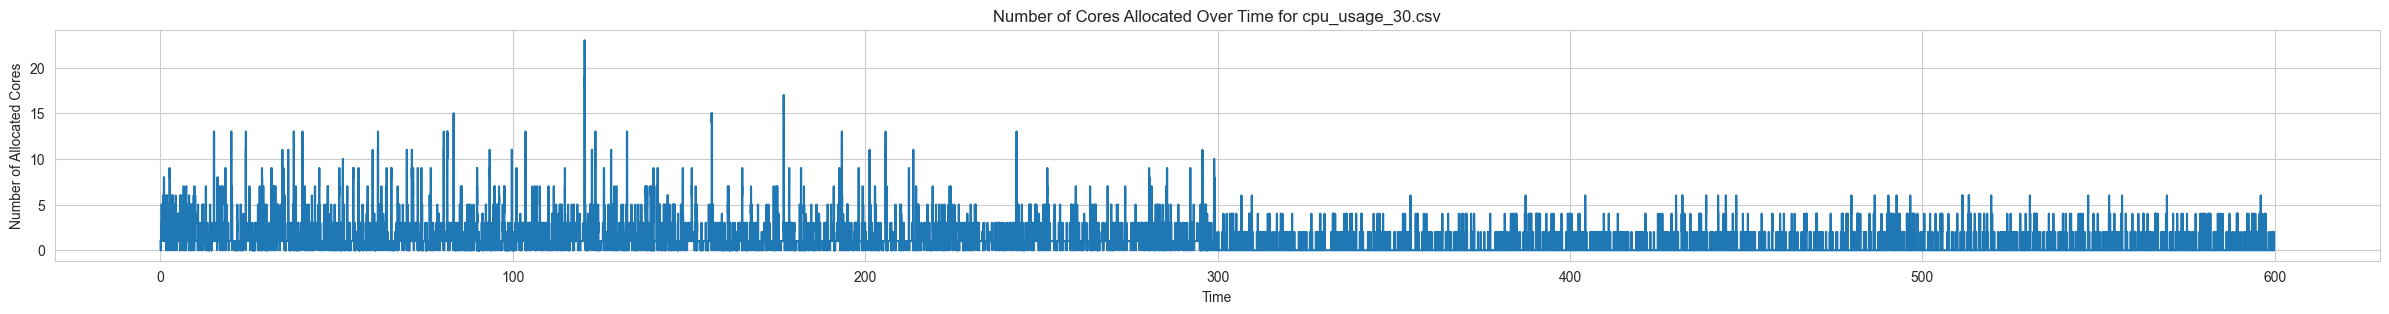

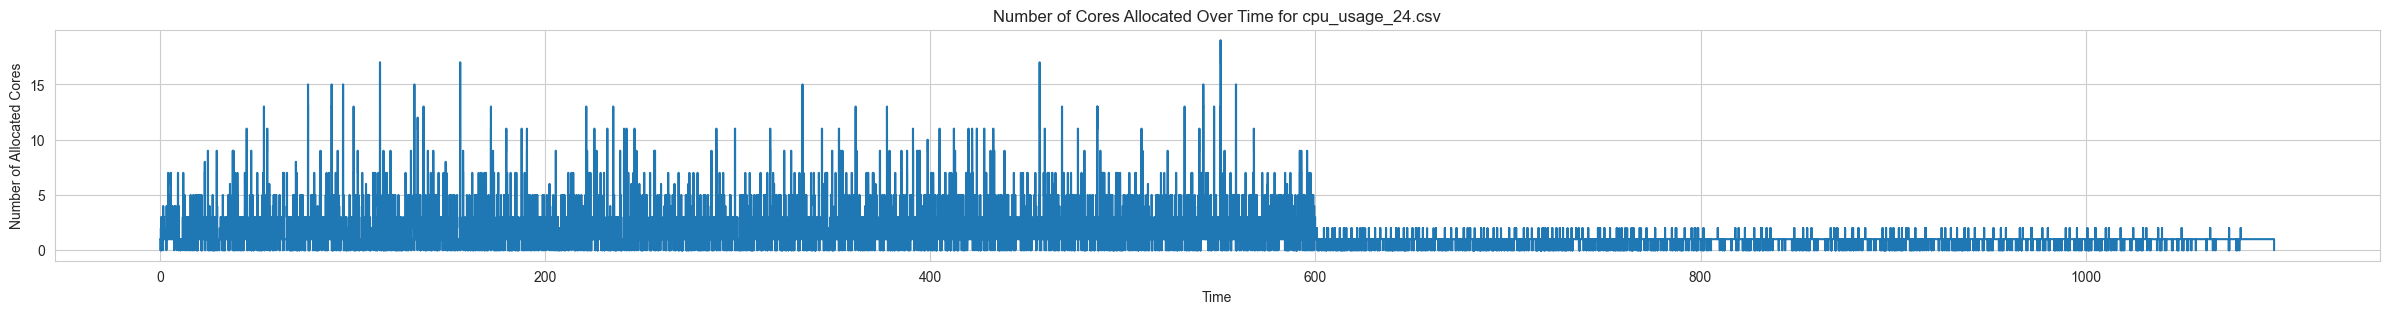

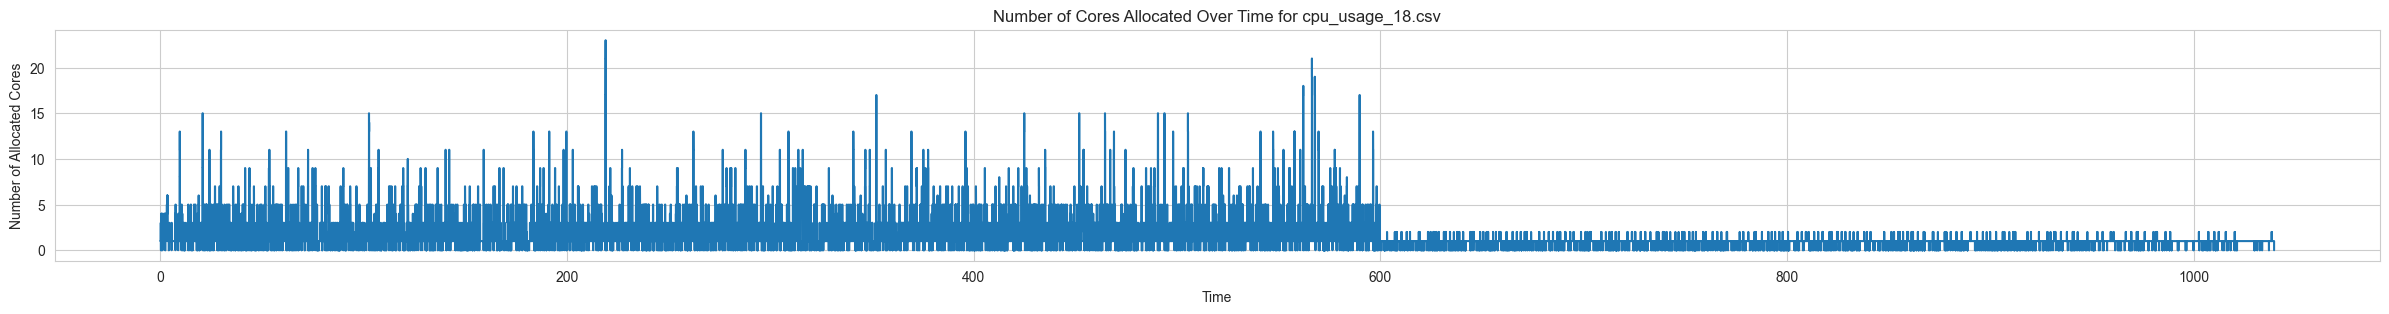

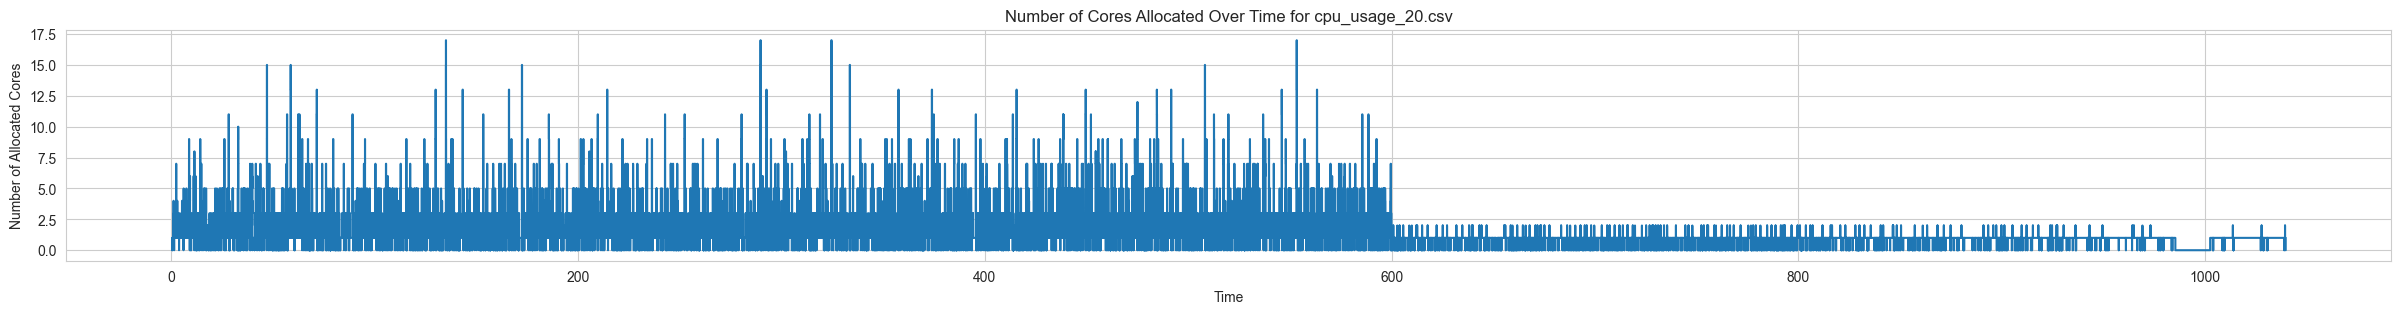

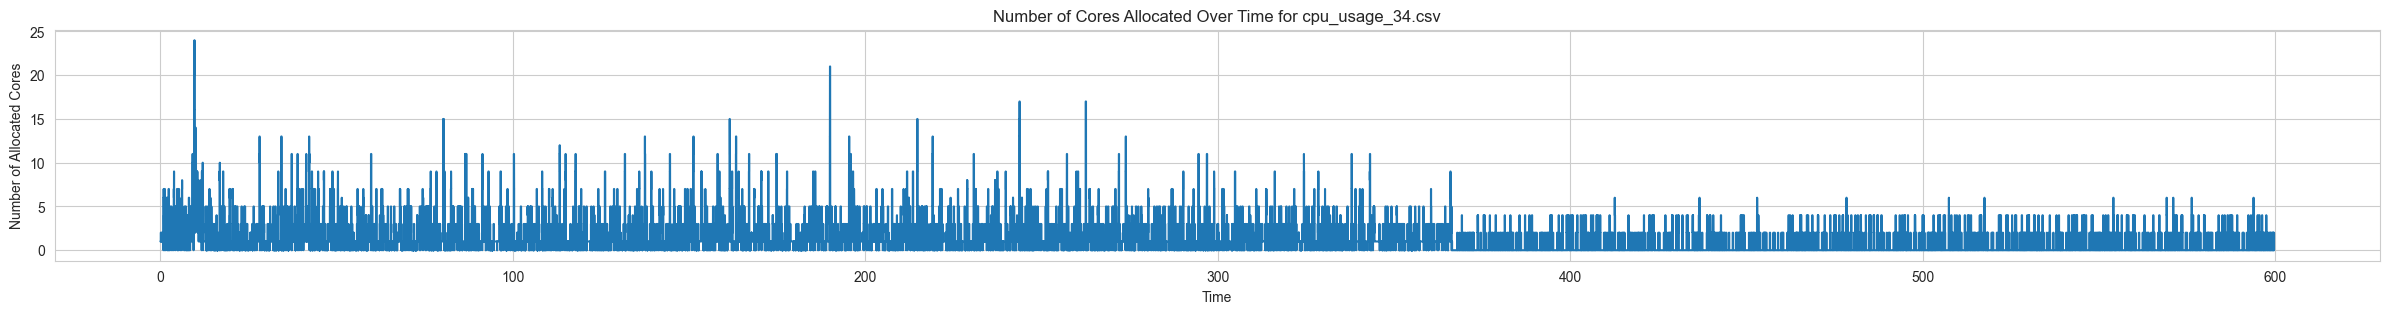

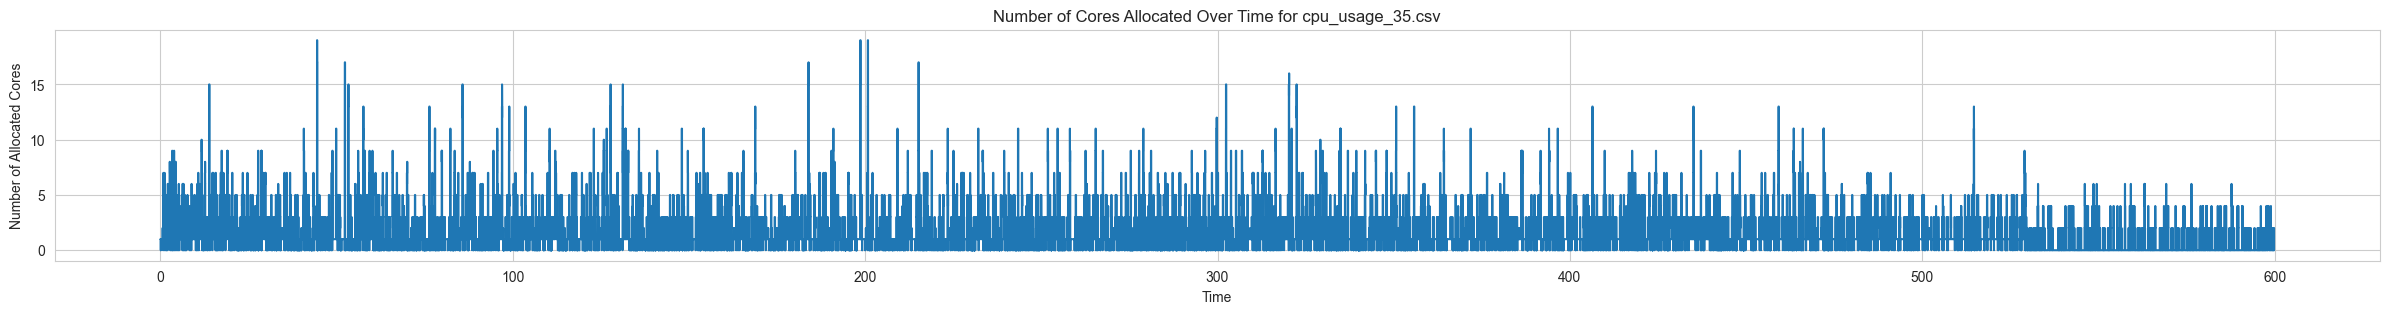

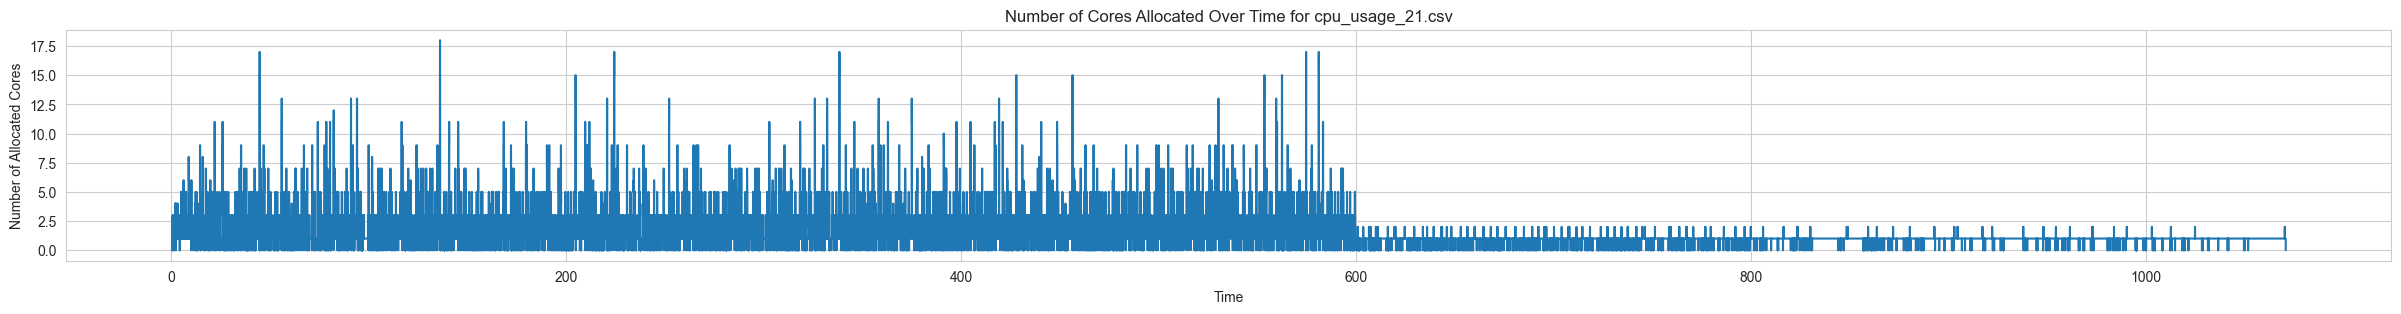

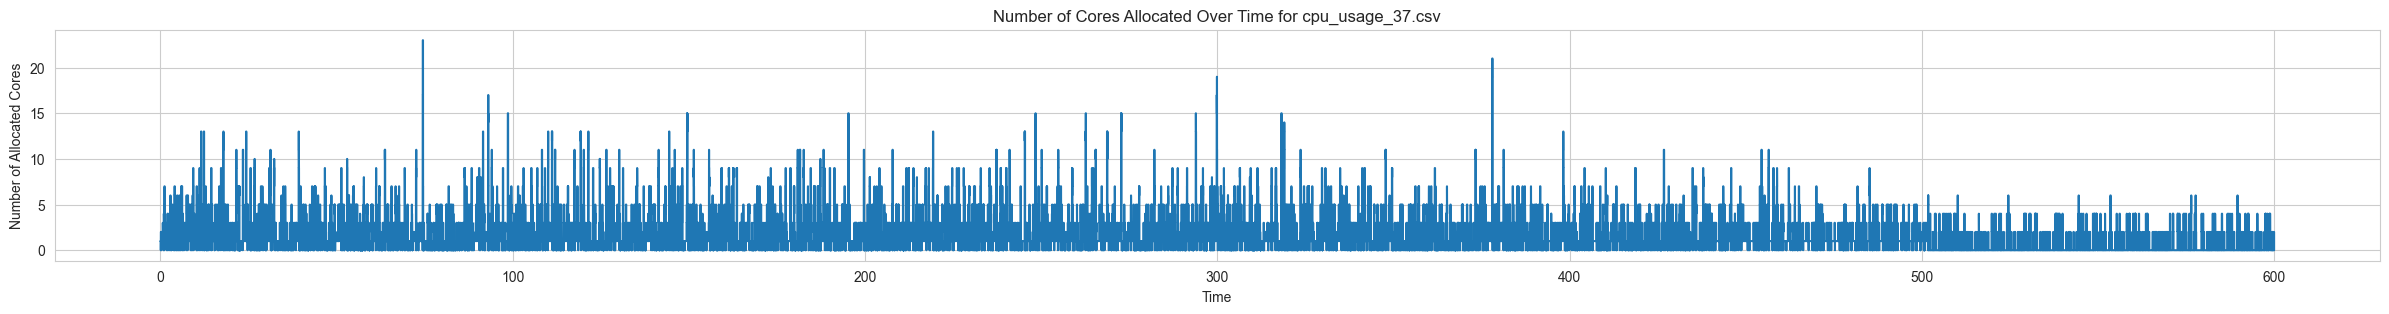

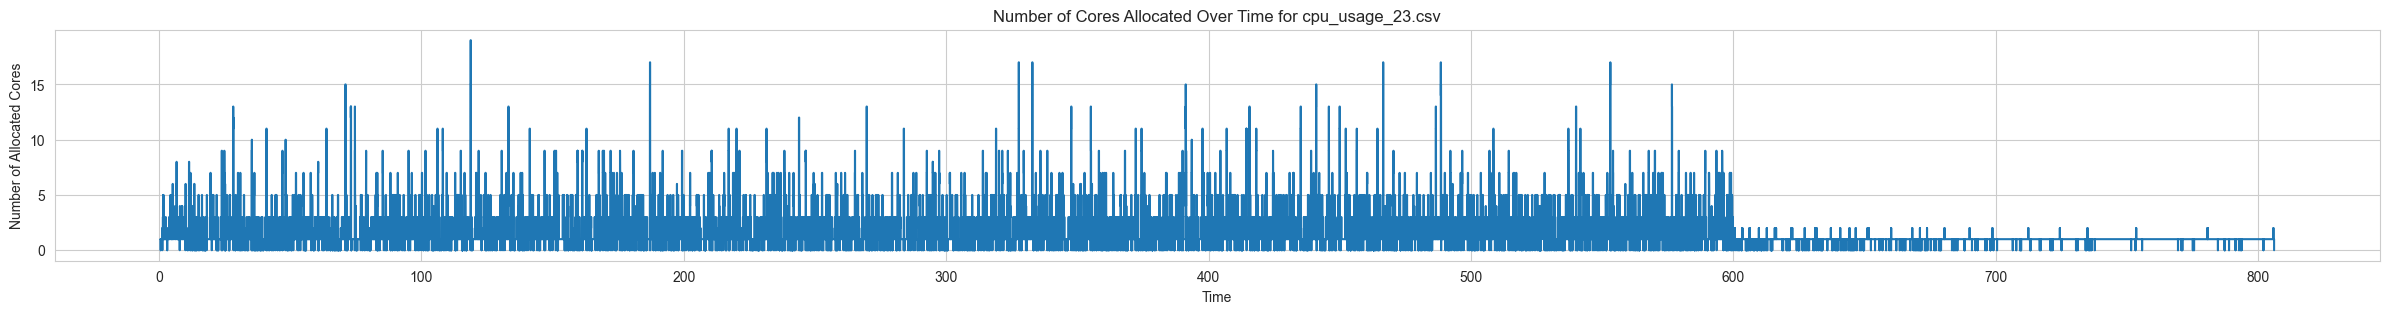

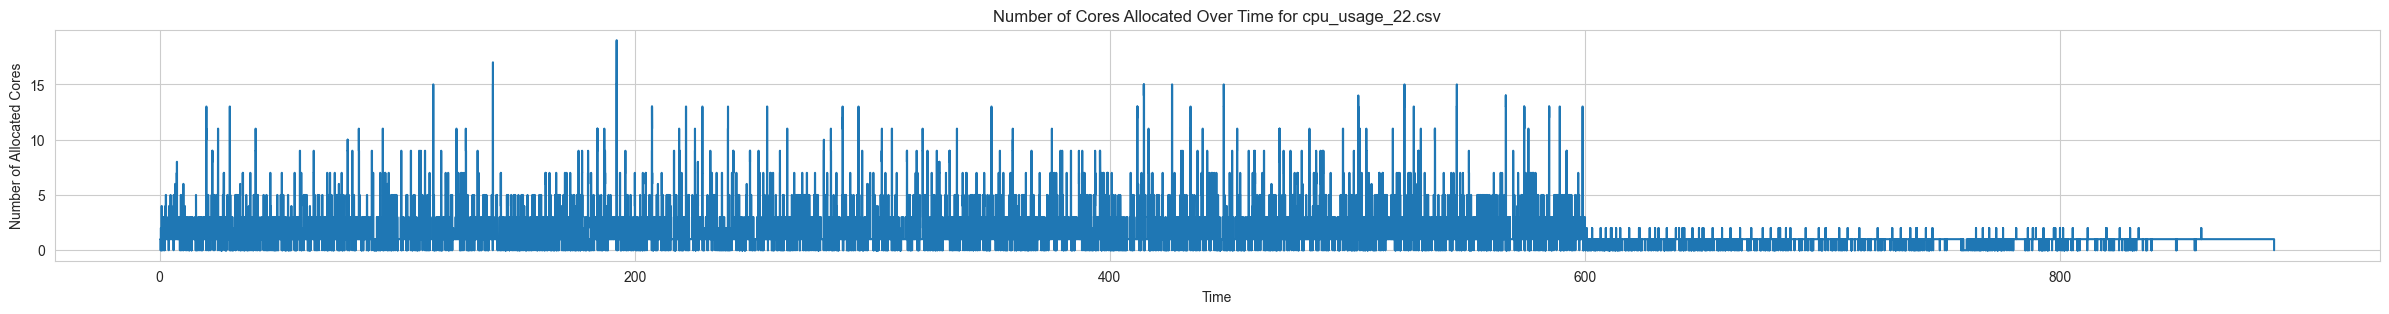

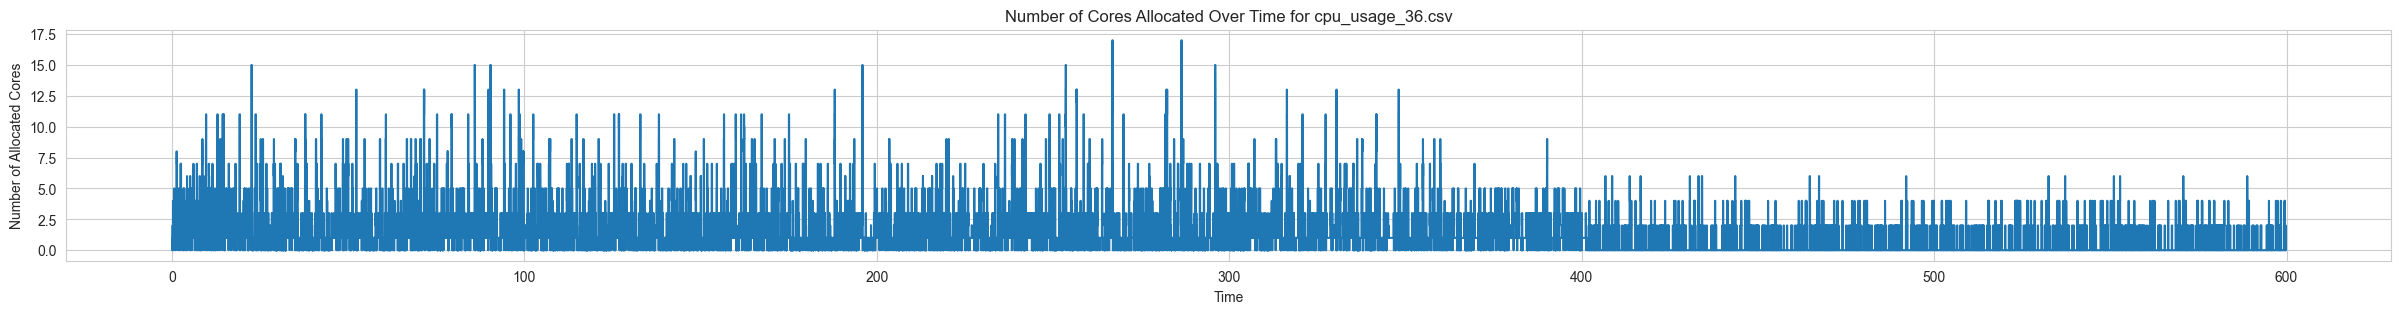

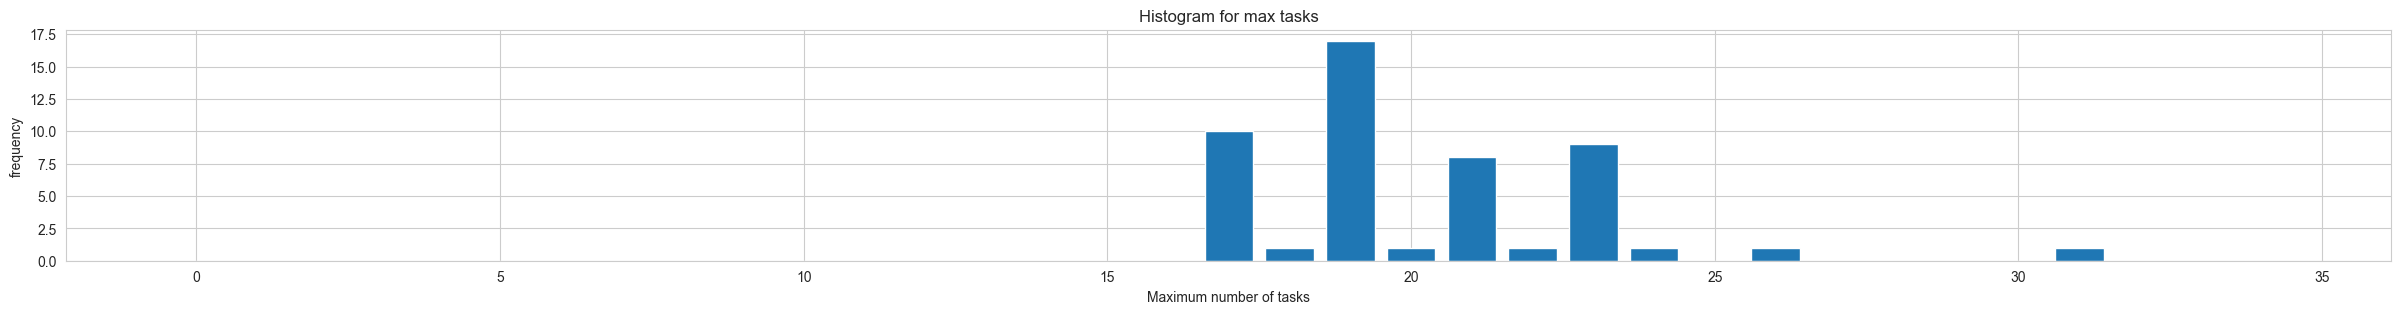

In [2]:
import numpy as np
import os


def cpu_task_analysis(experiment_root):
    folder = experiment_root + 'cpu_usage/'

    # load data
    max_running_tasks = []
    for f in os.listdir(folder):
        if f.startswith('cpu_usage_'):
            data_file = folder + f
            
            try:
                df = pd.read_csv(data_file)
            except Exception as e:
                print(f"Error reading file {data_file}: {e}")
                continue
            
            # Convert the 'clock' column to numeric
            df['clock'] = pd.to_numeric(df['clock'])
            
            # Sort the DataFrame by time
            df.sort_values('clock', inplace=True)
            
            # Initialize variables
            allocated_cores = set()
            times = []
            cores_count = []
            
            # Process each event
            for index, row in df.iterrows():
                time = row['clock']
                core_id = row['id']
                task = row['task']
            
                # Allocation event
                if pd.notna(task):
                    allocated_cores.add(core_id)
                # Deallocation event
                else:
                    allocated_cores.discard(core_id)
            
                # Record the time and current number of allocated cores
                times.append(time)
                cores_count.append(len(allocated_cores))
                
            max_running_tasks.append(max(cores_count))
            
            # Prepare data for step plot
            times_plot = [times[0]]
            cores_plot = [cores_count[0]]
            
            for i in range(1, len(times)):
                times_plot.extend([times[i-1], times[i]])
                cores_plot.extend([cores_count[i-1], cores_count[i]])
            
            # Plot the data
            plt.figure(figsize=(30, 3))
            plt.step(times_plot, cores_plot, where='post')
            plt.xlabel('Time')
            plt.ylabel('Number of Allocated Cores')
            plt.title('Number of Cores Allocated Over Time for ' + f)
            plt.grid(True)
            plt.show()
        
    # Plot the data
    plt.figure(figsize=(30, 3))
    
    # plot histogram of max running tasks
    plt.hist(max_running_tasks, bins=np.arange(0, max(max_running_tasks) + 1) - 0.5, rwidth=0.8)
    
    plt.xlabel('Maximum number of tasks')
    plt.ylabel('frequency')
    plt.title('Histogram for max tasks')
    plt.grid(True)
    plt.show()


cpu_task_analysis(experiment_root=experiment_root)